# import and define fuction

In [3]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import yaml

import panda2.panda2 as panda2
import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan
import panda2.analysis.interpreter as interpreter
import panda2.analysis.event_builder as event_builder

datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters'


def get_pix_tdac(fraw, npix=1): 
    with tb.open_file(fraw) as f:
        comp1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp1_before')))
        comp0 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp0_before')))
        tdac1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac1_before')))
        tdac0 = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac0_before')))
        arg = np.argwhere(comp1==1)
        if len(arg)!=npix:
            print('no comp1', arg, arg)
        else:
            return arg[0,0], arg[0,1], tdac1[arg[0,0], arg[0,1]]
        arg = np.argwhere(comp0==1)
        if len(arg)!=npix:
            print('no comp0', arg, arg)
        else:
            return arg[0,0], arg[0,1], tdac0[arg[0,0], arg[0,1]]
        return None
        
        
        
def get_conf(fraw, conf_name='IPDAC'):
    with tb.open_file(fraw) as f:
        conf = yaml.unsafe_load(f.root.meta_data.get_attr('firmware_before'))
        if conf_name in ['VDACBL']:
            return int(conf['CONF'][conf_name], 2)
        else:
            return int(conf['CONF'][conf_name][::-1], 2)

def plot_data(list_fraw):
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('IPDAC', 'i'), ('tdac','i')])
    for i, fraw in enumerate(list_fraw):
        fname = os.path.basename(fraw)
        fhit = fraw[:-7] + 'hit.h5'
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]
        col, row, tdac= get_pix_tdac(fraw)
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow
        #dat1 = dat[dat['comp']==0] #### fast   ##hui
        if len(dat1)!=0:
        #print(dat1)
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
            try:
                fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
                x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
                plt.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i%10))
            except:
                print(os.path.basename(fraw), nhit1)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            
            plt.plot(param['inj'], nhit1, 'C{}.'.format(i%10), label=label)
        
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            #ret[i]['noise']=fit[1+2]#ivan!!!
            ret[i]['th_err']=fit[2]#ivan !!! was 1+3 0 a 1 mu 2 sigma
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['tdac']=tdac
            ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')


            ## show x-axis and y-axis and legend
            plt.xlim(0,0.2)
            plt.xlabel('Injection[V]')
            plt.ylabel('#')
            plt.legend()
        else:
            print('no data for', col, row, 'tdac', tdac)
    return ret

def plot_data_png(list_fraw):
    print('starting png')
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('tdac', 'i')
                            #('IPDAC', 'i')
                           ])
    ## prepare for plot
    outdir = os.path.join(os.path.dirname(list_fraw[0]),"img")
    isExist = os.path.exists(outdir)
    if not isExist:
       os.makedirs(outdir)

    for i, fraw in enumerate(list_fraw):
        #print('i=')
        fname = os.path.basename(fraw)
        #print('test1')
        fhit = fraw[:-7] + 'hit.h5'
        #print('test2')
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]

        #print('test3')
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]

        #print('test4')
        col, row, tdac = get_pix_tdac(fraw)

        #print('test4b')
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow

        #print('before dat1 comp')

        #dat1 = dat[dat['comp']==0] #### fast   ##hui

        #print('after dat1 comp')

        if len(dat1)!=0:
            #print('len data1 is not 0')
            fig,ax = plt.subplots()
            #print('uni col row', np.unique(dat1['col']),  np.unique(dat1['row']))
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number'], minlength=len(param))
            
            fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
            x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            ax.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i))
            ax.plot(param['inj'], nhit1, 'C{}.'.format(i), label=label)
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            #ret[i]['noise']=fit[1+2]#ivan!!!
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['tdac']=tdac
            #ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')

            ## saving plot
            ax.set_xlim(0,0.2)
            ax.set_xlabel('Injection[V]')
            ax.set_ylabel('#')
            ax.legend()
            ax.set_title('{}-{} tdac={}'.format(col,row,tdac))
            fig.savefig(os.path.join(outdir,'{}-{}_tdac{}.png'.format(col,row,tdac)))
            plt.close()
        else:
            #print('len data1 is 0 :(')
            print('no data for ', col, row, 'tdac=', tdac, 'fname', os.path.basename(fraw))
    return ret

def plot_data_png_simple(list_fraw):
    print('starting png_simple')
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('tdac', 'i')
                            #('IPDAC', 'i')
                           ])
    ## prepare for plot
    outdir = os.path.join(os.path.dirname(list_fraw[0]),"img")
    isExist = os.path.exists(outdir)
    if not isExist:
       os.makedirs(outdir)

    for i, fraw in enumerate(list_fraw):
        #print('i=')
        fname = os.path.basename(fraw)
        #print('test1')
        fhit = fraw[:-7] + 'hit.h5'
        #print('test2')
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]

        #print('test3')
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]

        #print('test4')
        col, row, tdac = get_pix_tdac(fraw)

        #print('test4b')
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow

        #print('before dat1 comp')

        #dat1 = dat[dat['comp']==0] #### fast   ##hui

        #print('after dat1 comp')

        if len(dat1)!=0:
            #print('len data1 is not 0')
            fig,ax = plt.subplots()
            #print('uni col row', np.unique(dat1['col']),  np.unique(dat1['row']))
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number'], minlength=len(param))
            
            fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
            x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            #ax.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i))
            #ax.plot(param['inj'], nhit1, 'C{}.'.format(i), label=label)
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['tdac']=tdac
            #ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')

            ## saving plot
            #ax.set_xlim(0,0.2)
            #ax.set_xlabel('Injection[V]')
            #ax.set_ylabel('#')
            #ax.legend()
            #ax.set_title('{}-{} tdac={}'.format(col,row,tdac))
            #fig.savefig(os.path.join(outdir,'{}-{}_tdac{}.png'.format(col,row,tdac)))
            #plt.close()
        else:
            #print('len data1 is 0 :(')
            print('no data for ', col, row, 'tdac=', tdac, 'fname', os.path.basename(fraw))
    return ret


# analize raw data

In [4]:
## 
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall'

#datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan'

list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), ('tdac', 'i')
        ]

##########################
###  make Hit data ivan this makes hit files important
analyze = True
t0 = time.time()
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        fraw = os.path.join(datdir, fname)
        if analyze:
            fhit = fraw[:-7] + 'hit.h5'
            interpreter.interpret_h5(fraw, fhit)
            event_builder.build_h5(fraw=fraw, fhit=fhit)
        list_fraw.append(fraw)
    #print(time.time()-t0)


####### 
##  Do scurve scan

#print('i am alive')

ret=np.empty(len(list_fraw), dtype=dtype)    ##should change ret
for i, fraw in enumerate(list_fraw):
    print('i am alive')
    ret[i] = plot_data_png([fraw])           ##should change ret
    if i%100==0:
        print('time for calculation ({0}/{1}) {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             )
try:
   os.makedirs(os.path.join(datdir,'results'))
except:
    pass

retname = os.path.join(os.path.join(datdir,'results'), 'res.npy')
np.save(retname, ret)
tdacall = np.load(retname)  ### change variable name 

2024-06-15 15:25:28,198 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:28,198 - root - [INFO    ] (MainThread) 0.00s hit=810/810 event=808 ts=2600/2600


2024-06-15 15:25:28,206 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:28,206 - root - [INFO    ] (MainThread) 0.00s hit=1191/1191 event=1189 ts=2600/2600
2024-06-15 15:25:28,213 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:28,213 - root - [INFO    ] (MainThread) 0.00s hit=885/885 event=882 ts=2600/2600
2024-06-15 15:25:28,220 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:28,220 - root - [INFO    ] (MainThread) 0.00s hit=959/959 event=954 ts=2600/2600
2024-06-15 15:25:28,226 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:28,227 - root - [INFO    ] (MainThread) 0.00s hit=1120/1120 event=1110 ts=2600/2600
2024-06-15 15:25:28,233 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:28,233 - root - [INFO    ] (MainThread) 0.00s hit=1178/1178 event=1176 ts=2600/2600
2024-06-15 15:25:28,239 - root - [INFO    ] (MainThread

0.00s 11842/11842 hit=810 ts=2600
0.00s 13747/13747 hit=1191 ts=2600
0.00s 12213/12213 hit=885 ts=2600
0.00s 12576/12576 hit=959 ts=2600
0.00s 13362/13362 hit=1120 ts=2600
0.00s 13682/13682 hit=1178 ts=2600
0.00s 13439/13439 hit=1137 ts=2600
0.00s 13468/13468 hit=1139 ts=2600
0.00s 13417/13417 hit=1125 ts=2600
0.00s 12295/12295 hit=905 ts=2600
0.00s 12865/12865 hit=1013 ts=2600
0.00s 12611/12611 hit=963 ts=2600
0.00s 12309/12309 hit=908 ts=2600
0.00s 12706/12706 hit=982 ts=2600
0.00s 12345/12345 hit=909 ts=2600
0.00s 11046/11046 hit=653 ts=2600
0.00s 12682/12682 hit=978 ts=2600
0.00s 12995/12995 hit=1047 ts=2600
0.00s 13023/13023 hit=1050 ts=2600
0.00s 13439/13439 hit=1131 ts=2600
0.00s 12548/12548 hit=951 ts=2600
0.00s 12819/12819 hit=1007 ts=2600
0.00s 13084/13084 hit=1060 ts=2600
0.00s 13801/13801 hit=1201 ts=2600
0.00s 12569/12569 hit=960 ts=2600
0.00s 13405/13405 hit=1121 ts=2600
0.00s 13056/13056 hit=1059 ts=2600
0.00s 13783/13783 hit=1202 ts=2600
0.00s 13264/13264 hit=1102 ts=26

2024-06-15 15:25:28,398 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:28,399 - root - [INFO    ] (MainThread) 0.00s hit=1102/1102 event=1090 ts=2600/2600
2024-06-15 15:25:28,405 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:28,405 - root - [INFO    ] (MainThread) 0.00s hit=1069/1069 event=1066 ts=2600/2600
2024-06-15 15:25:28,412 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:28,413 - root - [INFO    ] (MainThread) 0.00s hit=1052/1052 event=1050 ts=2600/2600
2024-06-15 15:25:28,419 - root - [INFO    ] (MainThread) 0.00s hit=1129/1129 event=1129 ts=2600/2600
2024-06-15 15:25:28,425 - root - [INFO    ] (MainThread) 0.00s hit=964/964 event=964 ts=2600/2600
2024-06-15 15:25:28,432 - root - [INFO    ] (MainThread) 0.00s hit=1209/1209 event=1209 ts=2600/2600
2024-06-15 15:25:28,438 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:28,438 - root - [INFO  

0.00s 13133/13133 hit=1069 ts=2600
0.00s 13052/13052 hit=1052 ts=2600
0.00s 13445/13445 hit=1129 ts=2600
0.00s 12620/12620 hit=964 ts=2600
0.00s 13845/13845 hit=1209 ts=2600
0.00s 11682/11682 hit=777 ts=2600
0.00s 14120/14120 hit=1264 ts=2600
0.00s 13609/13609 hit=1171 ts=2600
0.00s 12952/12952 hit=1032 ts=2600
0.00s 13068/13068 hit=1062 ts=2600
0.00s 13478/13478 hit=1141 ts=2600
0.00s 13032/13032 hit=1048 ts=2600
0.00s 13537/13537 hit=1152 ts=2600
0.00s 11738/11738 hit=790 ts=2600
0.00s 12466/12466 hit=937 ts=2600
0.00s 13370/13370 hit=1124 ts=2600
0.00s 13727/13727 hit=1190 ts=2600
0.00s 12168/12168 hit=879 ts=2600
0.00s 12901/12901 hit=1021 ts=2600
0.00s 12353/12353 hit=916 ts=2600
0.00s 12132/12132 hit=874 ts=2600
0.00s 11597/11597 hit=761 ts=2600
0.00s 12828/12828 hit=1011 ts=2600
0.00s 12692/12692 hit=980 ts=2600
0.00s 13672/13672 hit=1176 ts=2600
0.00s 14397/14397 hit=1328 ts=2600
0.00s 13264/13264 hit=1096 ts=2600
0.00s 14052/14052 hit=1252 ts=2600
0.00s 12211/12211 hit=886 ts=

2024-06-15 15:25:28,606 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:28,606 - root - [INFO    ] (MainThread) 0.00s hit=1094/1094 event=1088 ts=2600/2600
2024-06-15 15:25:28,612 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:28,612 - root - [INFO    ] (MainThread) 0.00s hit=1050/1050 event=1049 ts=2600/2600
2024-06-15 15:25:28,618 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:28,619 - root - [INFO    ] (MainThread) 0.00s hit=836/836 event=834 ts=2600/2600
2024-06-15 15:25:28,625 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:28,625 - root - [INFO    ] (MainThread) 0.00s hit=1030/1030 event=1029 ts=2600/2600
2024-06-15 15:25:28,631 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:28,632 - root - [INFO    ] (MainThread) 0.00s hit=1118/1118 event=1114 ts=2600/2600
2024-06-15 15:25:28,637 - root - [INFO    ] (MainThre

0.00s 13247/13247 hit=1094 ts=2600
0.00s 13046/13046 hit=1050 ts=2600
0.00s 11972/11972 hit=836 ts=2600
0.00s 12946/12946 hit=1030 ts=2600
0.00s 13374/13374 hit=1118 ts=2600
0.00s 13009/13009 hit=1051 ts=2600
0.00s 12099/12099 hit=862 ts=2600
0.00s 12081/12081 hit=857 ts=2600
0.00s 12499/12499 hit=948 ts=2600
0.00s 13084/13084 hit=1062 ts=2600
0.00s 12883/12883 hit=1019 ts=2600
0.00s 13226/13226 hit=1089 ts=2600
0.00s 13529/13529 hit=1153 ts=2600
0.00s 12874/12874 hit=1019 ts=2600
0.00s 13822/13822 hit=1206 ts=2600
0.00s 14031/14031 hit=1250 ts=2600
0.00s 12189/12189 hit=887 ts=2600
0.00s 13553/13553 hit=1159 ts=2600
0.00s 14796/14796 hit=1403 ts=2600
0.00s 13437/13437 hit=1129 ts=2600
0.00s 14255/14255 hit=1291 ts=2600
0.00s 12324/12324 hit=908 ts=2600
0.00s 13043/13043 hit=1051 ts=2600
0.00s 12976/12976 hit=1039 ts=2600
0.00s 13666/13666 hit=1177 ts=2600
0.00s 12989/12989 hit=1041 ts=2600
0.00s 13063/13063 hit=1055 ts=2600
0.00s 13618/13618 hit=1169 ts=2600
0.00s 13734/13734 hit=1192

2024-06-15 15:25:28,805 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:28,805 - root - [INFO    ] (MainThread) 0.00s hit=1192/1192 event=1185 ts=2600/2600
2024-06-15 15:25:28,812 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:28,813 - root - [INFO    ] (MainThread) 0.00s hit=1146/1146 event=1140 ts=2600/2600
2024-06-15 15:25:28,820 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:28,820 - root - [INFO    ] (MainThread) 0.00s hit=889/889 event=877 ts=2600/2600
2024-06-15 15:25:28,827 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:28,827 - root - [INFO    ] (MainThread) 0.00s hit=1119/1119 event=1114 ts=2600/2600
2024-06-15 15:25:28,839 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:28,840 - root - [INFO    ] (MainThread) 0.00s hit=1004/1004 event=1003 ts=2600/2600
2024-06-15 15:25:28,846 - root - [INFO    ] (MainThr

0.00s 13507/13507 hit=1146 ts=2600
0.00s 12199/12199 hit=889 ts=2600
0.00s 13375/13375 hit=1119 ts=2600
0.00s 12816/12816 hit=1004 ts=2600
0.00s 12793/12793 hit=1014 ts=2600
0.00s 13289/13289 hit=1104 ts=2600
0.00s 13093/13093 hit=1064 ts=2600
0.00s 12484/12484 hit=939 ts=2600
0.00s 12917/12917 hit=1024 ts=2600
0.00s 13311/13311 hit=1103 ts=2600
0.00s 12962/12962 hit=1037 ts=2600
0.00s 13741/13741 hit=1189 ts=2600
0.00s 13885/13885 hit=1220 ts=2600
0.00s 14471/14471 hit=1338 ts=2600
0.00s 14212/14212 hit=1284 ts=2600
0.00s 13523/13523 hit=1149 ts=2600
0.00s 11526/11526 hit=746 ts=2600
0.00s 13032/13032 hit=1051 ts=2600
0.00s 13275/13275 hit=1095 ts=2600
0.00s 12118/12118 hit=866 ts=2600
0.00s 12894/12894 hit=1031 ts=2600
0.00s 13163/13163 hit=1074 ts=2600
0.00s 12889/12889 hit=1021 ts=2600
0.00s 12716/12716 hit=991 ts=2600
0.00s 12795/12795 hit=999 ts=2600
0.00s 13757/13757 hit=1193 ts=2600
0.00s 10615/10615 hit=565 ts=2600
0.00s 12081/12081 hit=857 ts=2600


2024-06-15 15:25:29,014 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:29,015 - root - [INFO    ] (MainThread) 0.00s hit=1036/1036 event=1033 ts=2600/2600
2024-06-15 15:25:29,022 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:29,022 - root - [INFO    ] (MainThread) 0.00s hit=1013/1013 event=1001 ts=2600/2600
2024-06-15 15:25:29,029 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:29,029 - root - [INFO    ] (MainThread) 0.00s hit=978/978 event=976 ts=2600/2600
2024-06-15 15:25:29,037 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:29,038 - root - [INFO    ] (MainThread) 0.00s hit=996/996 event=993 ts=2600/2600
2024-06-15 15:25:29,044 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:29,044 - root - [INFO    ] (MainThread) 0.00s hit=1107/1107 event=1100 ts=2600/2600
2024-06-15 15:25:29,050 - root - [INFO    ] (MainThread

0.00s 12970/12970 hit=1036 ts=2600
0.00s 12819/12819 hit=1013 ts=2600
0.00s 12682/12682 hit=978 ts=2600
0.00s 12768/12768 hit=996 ts=2600
0.00s 13308/13308 hit=1107 ts=2600
0.00s 13087/13087 hit=1059 ts=2600
0.00s 13110/13110 hit=1062 ts=2600
0.00s 10681/10681 hit=580 ts=2600
0.00s 12666/12666 hit=977 ts=2600
0.00s 12389/12389 hit=921 ts=2600
0.00s 14260/14260 hit=1292 ts=2600
0.00s 12469/12469 hit=939 ts=2600
0.00s 12987/12987 hit=1042 ts=2600
0.00s 11583/11583 hit=759 ts=2600
0.00s 13263/13263 hit=1098 ts=2600
0.00s 11461/11461 hit=733 ts=2600
0.00s 12988/12988 hit=1040 ts=2600
0.00s 14043/14043 hit=1260 ts=2600
0.00s 14005/14005 hit=1250 ts=2600
0.00s 13658/13658 hit=1174 ts=2600
0.00s 12306/12306 hit=905 ts=2600
0.00s 13363/13363 hit=1115 ts=2600
0.00s 13511/13511 hit=1153 ts=2600
0.00s 13818/13818 hit=1212 ts=2600
0.00s 11902/11902 hit=822 ts=2600
0.00s 12317/12317 hit=905 ts=2600
0.00s 13508/13508 hit=1144 ts=2600
0.00s 11922/11922 hit=829 ts=2600
0.00s 13458/13458 hit=1134 ts=26

2024-06-15 15:25:29,217 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:29,217 - root - [INFO    ] (MainThread) 0.00s hit=1096/1096 event=1095 ts=2600/2600
2024-06-15 15:25:29,224 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:29,224 - root - [INFO    ] (MainThread) 0.00s hit=1050/1050 event=1046 ts=2600/2600
2024-06-15 15:25:29,231 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:29,231 - root - [INFO    ] (MainThread) 0.00s hit=1039/1039 event=1033 ts=2600/2600
2024-06-15 15:25:29,238 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:29,238 - root - [INFO    ] (MainThread) 0.00s hit=1116/1116 event=1110 ts=2600/2600
2024-06-15 15:25:29,244 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:29,245 - root - [INFO    ] (MainThread) 0.00s hit=866/866 event=864 ts=2600/2600
2024-06-15 15:25:29,251 - root - [INFO    ] (MainThre

0.00s 13276/13276 hit=1096 ts=2600
0.00s 13034/13034 hit=1050 ts=2600
0.00s 12972/12972 hit=1039 ts=2600
0.00s 13357/13357 hit=1116 ts=2600
0.00s 12122/12122 hit=866 ts=2600
0.00s 13431/13431 hit=1127 ts=2600
0.00s 13772/13772 hit=1199 ts=2600
0.00s 12411/12411 hit=926 ts=2600
0.00s 13101/13101 hit=1061 ts=2600
0.00s 13351/13351 hit=1111 ts=2600
0.00s 14286/14286 hit=1298 ts=2600
0.00s 14034/14034 hit=1250 ts=2600
0.00s 13231/13231 hit=1087 ts=2600
0.00s 12726/12726 hit=986 ts=2600
0.00s 12582/12582 hit=958 ts=2600
0.00s 13571/13571 hit=1158 ts=2600
0.00s 13268/13268 hit=1099 ts=2600
0.00s 12659/12659 hit=978 ts=2600
0.00s 12241/12241 hit=889 ts=2600
0.00s 12844/12844 hit=1011 ts=2600
0.00s 12497/12497 hit=941 ts=2600
0.00s 12621/12621 hit=965 ts=2600
0.00s 13754/13754 hit=1197 ts=2600
0.00s 13795/13795 hit=1199 ts=2600
0.00s 13013/13013 hit=1044 ts=2600
0.00s 13219/13219 hit=1089 ts=2600
0.00s 13200/13200 hit=1083 ts=2600


2024-06-15 15:25:29,420 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:29,420 - root - [INFO    ] (MainThread) 0.00s hit=1083/1083 event=1079 ts=2600/2600
2024-06-15 15:25:29,434 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:29,435 - root - [INFO    ] (MainThread) 0.00s hit=1079/1079 event=1074 ts=2600/2600
2024-06-15 15:25:29,449 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:29,449 - root - [INFO    ] (MainThread) 0.00s hit=938/938 event=933 ts=2600/2600
2024-06-15 15:25:29,458 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:29,459 - root - [INFO    ] (MainThread) 0.00s hit=1038/1038 event=1031 ts=2600/2600
2024-06-15 15:25:29,465 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:29,466 - root - [INFO    ] (MainThread) 0.00s hit=1095/1095 event=1093 ts=2600/2600
2024-06-15 15:25:29,473 - root - [INFO    ] (MainThre

0.00s 13176/13176 hit=1079 ts=2600
0.00s 12471/12471 hit=938 ts=2600
0.00s 12963/12963 hit=1038 ts=2600
0.00s 13267/13267 hit=1095 ts=2600
0.00s 13308/13308 hit=1107 ts=2600
0.00s 12437/12437 hit=929 ts=2600
0.00s 14240/14240 hit=1288 ts=2600
0.00s 12801/12801 hit=1001 ts=2600
0.00s 12957/12957 hit=1033 ts=2600
0.00s 12894/12894 hit=1029 ts=2600
0.00s 13521/13521 hit=1145 ts=2600
0.00s 12998/12998 hit=1042 ts=2600
0.00s 12437/12437 hit=929 ts=2600
0.00s 14270/14270 hit=1294 ts=2600
0.00s 12847/12847 hit=1011 ts=2600
0.00s 13137/13137 hit=1069 ts=2600
0.00s 13887/13887 hit=1219 ts=2600
0.00s 14274/14274 hit=1298 ts=2600
0.00s 14023/14023 hit=1246 ts=2600
0.00s 14121/14121 hit=1265 ts=2600
0.00s 13962/13962 hit=1234 ts=2600
0.00s 12952/12952 hit=1035 ts=2600
0.00s 13447/13447 hit=1137 ts=2600
0.00s 13263/13263 hit=1095 ts=2600
0.00s 13039/13039 hit=1054 ts=2600
0.00s 13286/13286 hit=1102 ts=2600
0.00s 13089/13089 hit=1061 ts=2600


2024-06-15 15:25:29,630 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:29,632 - root - [INFO    ] (MainThread) 0.00s hit=1061/1061 event=1057 ts=2600/2600
2024-06-15 15:25:29,644 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:29,645 - root - [INFO    ] (MainThread) 0.00s hit=862/862 event=850 ts=2600/2600
2024-06-15 15:25:29,659 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:29,659 - root - [INFO    ] (MainThread) 0.00s hit=1144/1144 event=1143 ts=2600/2600
2024-06-15 15:25:29,672 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:29,673 - root - [INFO    ] (MainThread) 0.00s hit=1155/1155 event=1149 ts=2600/2600
2024-06-15 15:25:29,680 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:29,681 - root - [INFO    ] (MainThread) 0.00s hit=1144/1144 event=1139 ts=2600/2600
2024-06-15 15:25:29,687 - root - [INFO    ] (MainThr

0.00s 12067/12067 hit=862 ts=2600
0.00s 13516/13516 hit=1144 ts=2600
0.00s 13552/13552 hit=1155 ts=2600
0.00s 13501/13501 hit=1144 ts=2600
0.00s 14118/14118 hit=1269 ts=2600
0.00s 13082/13082 hit=1058 ts=2600
0.00s 13366/13366 hit=1114 ts=2600
0.00s 13705/13705 hit=1190 ts=2600
0.00s 14176/14176 hit=1286 ts=2600
0.00s 13283/13283 hit=1098 ts=2600
0.00s 13980/13980 hit=1242 ts=2600
0.00s 13541/13541 hit=1149 ts=2600
0.00s 14318/14318 hit=1309 ts=2600
0.00s 13823/13823 hit=1210 ts=2600
0.00s 13830/13830 hit=1206 ts=2600
0.00s 13518/13518 hit=1149 ts=2600
0.00s 13859/13859 hit=1218 ts=2600
0.00s 13307/13307 hit=1103 ts=2600
0.00s 14251/14251 hit=1291 ts=2600
0.00s 12450/12450 hit=942 ts=2600
0.00s 14782/14782 hit=1398 ts=2600
0.00s 14185/14185 hit=1277 ts=2600
0.00s 13549/13549 hit=1153 ts=2600
0.00s 13595/13595 hit=1159 ts=2600
0.00s 14074/14074 hit=1260 ts=2600
0.00s 13676/13676 hit=1176 ts=2600
0.00s 13918/13918 hit=1229 ts=2600
0.00s 12462/12462 hit=940 ts=2600
0.00s 13207/13207 hit=1

2024-06-15 15:25:29,842 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:29,843 - root - [INFO    ] (MainThread) 0.00s hit=1089/1089 event=1079 ts=2600/2600
2024-06-15 15:25:29,849 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:29,849 - root - [INFO    ] (MainThread) 0.00s hit=1215/1215 event=1208 ts=2600/2600
2024-06-15 15:25:29,855 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:29,855 - root - [INFO    ] (MainThread) 0.00s hit=1313/1313 event=1312 ts=2600/2600
2024-06-15 15:25:29,861 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:29,862 - root - [INFO    ] (MainThread) 0.00s hit=974/974 event=972 ts=2600/2600
2024-06-15 15:25:29,868 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:29,868 - root - [INFO    ] (MainThread) 0.00s hit=1118/1118 event=1116 ts=2600/2600
2024-06-15 15:25:29,876 - root - [INFO    ] (MainThr

0.00s 13848/13848 hit=1215 ts=2600
0.00s 14361/14361 hit=1313 ts=2600
0.00s 12662/12662 hit=974 ts=2600
0.00s 13383/13383 hit=1118 ts=2600
0.00s 12925/12925 hit=1025 ts=2600
0.00s 12790/12790 hit=1012 ts=2600
0.00s 12391/12391 hit=919 ts=2600
0.00s 13444/13444 hit=1132 ts=2600
0.00s 13192/13192 hit=1080 ts=2600
0.00s 14207/14207 hit=1286 ts=2600
0.00s 14927/14927 hit=1430 ts=2600
0.00s 13720/13720 hit=1184 ts=2600
0.00s 14792/14792 hit=1400 ts=2600
0.00s 13046/13046 hit=1053 ts=2600
0.00s 13047/13047 hit=1051 ts=2600
0.00s 13272/13272 hit=1099 ts=2600
0.00s 13792/13792 hit=1203 ts=2600
0.00s 13674/13674 hit=1181 ts=2600
0.00s 12552/12552 hit=955 ts=2600
0.00s 13498/13498 hit=1141 ts=2600
0.00s 13847/13847 hit=1211 ts=2600
0.00s 13491/13491 hit=1139 ts=2600
0.00s 12699/12699 hit=982 ts=2600
0.00s 12836/12836 hit=1015 ts=2600
0.00s 13136/13136 hit=1068 ts=2600
0.00s 13630/13630 hit=1166 ts=2600
0.00s 13452/13452 hit=1135 ts=2600
0.00s 13733/13733 hit=1192 ts=2600


2024-06-15 15:25:30,048 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:30,048 - root - [INFO    ] (MainThread) 0.00s hit=1192/1192 event=1185 ts=2600/2600
2024-06-15 15:25:30,055 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-06-15 15:25:30,056 - root - [INFO    ] (MainThread) 0.00s hit=1266/1266 event=1257 ts=2600/2600
2024-06-15 15:25:30,063 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:30,063 - root - [INFO    ] (MainThread) 0.00s hit=1120/1120 event=1119 ts=2600/2600
2024-06-15 15:25:30,069 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=15
2024-06-15 15:25:30,070 - root - [INFO    ] (MainThread) 0.00s hit=1318/1318 event=1303 ts=2600/2600
2024-06-15 15:25:30,076 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:30,076 - root - [INFO    ] (MainThread) 0.00s hit=1365/1365 event=1357 ts=2600/2600
2024-06-15 15:25:30,088 - root - [INFO    ] (Main

0.00s 14095/14095 hit=1266 ts=2600
0.00s 13396/13396 hit=1120 ts=2600
0.00s 14332/14332 hit=1318 ts=2600
0.00s 14594/14594 hit=1365 ts=2600
0.00s 12756/12756 hit=992 ts=2600
0.00s 14096/14096 hit=1260 ts=2600
0.00s 15254/15254 hit=1500 ts=2600
0.00s 14073/14073 hit=1260 ts=2600
0.00s 14751/14751 hit=1391 ts=2600
0.00s 12893/12893 hit=1020 ts=2600
0.00s 13690/13690 hit=1178 ts=2600
0.00s 13531/13531 hit=1150 ts=2600
0.00s 14116/14116 hit=1264 ts=2600
0.00s 13560/13560 hit=1152 ts=2600
0.00s 13476/13476 hit=1136 ts=2600
0.00s 14183/14183 hit=1282 ts=2600
0.00s 14374/14374 hit=1321 ts=2600
0.00s 14106/14106 hit=1262 ts=2600
0.00s 12952/12952 hit=1038 ts=2600
0.00s 13847/13847 hit=1214 ts=2600
0.00s 13471/13471 hit=1135 ts=2600
0.00s 13457/13457 hit=1136 ts=2600
0.00s 13827/13827 hit=1213 ts=2600
0.00s 13576/13576 hit=1156 ts=2600
0.00s 13011/13011 hit=1043 ts=2600
0.00s 13607/13607 hit=1175 ts=2600
0.00s 13781/13781 hit=1197 ts=2600
0.00s 13509/13509 hit=1145 ts=2600
0.00s 14240/14240 hit

2024-06-15 15:25:30,255 - root - [INFO    ] (MainThread) 0.00s hit=1288/1288 event=1288 ts=2600/2600
2024-06-15 15:25:30,261 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:30,262 - root - [INFO    ] (MainThread) 0.00s hit=1330/1330 event=1324 ts=2600/2600
2024-06-15 15:25:30,268 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:30,268 - root - [INFO    ] (MainThread) 0.00s hit=1439/1439 event=1438 ts=2600/2600
2024-06-15 15:25:30,274 - root - [INFO    ] (MainThread) 0.00s hit=1371/1371 event=1371 ts=2600/2600
2024-06-15 15:25:30,280 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:30,281 - root - [INFO    ] (MainThread) 0.00s hit=1283/1283 event=1277 ts=2600/2600
2024-06-15 15:25:30,287 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:30,287 - root - [INFO    ] (MainThread) 0.00s hit=865/865 event=855 ts=2600/2600
2024-06-15 15:25:30,293 - root - [INFO  

0.00s 14427/14427 hit=1330 ts=2600
0.00s 14991/14991 hit=1439 ts=2600
0.00s 14655/14655 hit=1371 ts=2600
0.00s 14192/14192 hit=1283 ts=2600
0.00s 12087/12087 hit=865 ts=2600
0.00s 13507/13507 hit=1146 ts=2600
0.00s 13923/13923 hit=1230 ts=2600
0.00s 12732/12732 hit=991 ts=2600
0.00s 13433/13433 hit=1132 ts=2600
0.00s 13587/13587 hit=1162 ts=2600
0.00s 13496/13496 hit=1140 ts=2600
0.00s 13323/13323 hit=1107 ts=2600
0.00s 13337/13337 hit=1109 ts=2600
0.00s 14203/14203 hit=1283 ts=2600
0.00s 11494/11494 hit=742 ts=2600
0.00s 12680/12680 hit=983 ts=2600
0.00s 13536/13536 hit=1151 ts=2600
0.00s 13350/13350 hit=1110 ts=2600
0.00s 13289/13289 hit=1101 ts=2600
0.00s 13366/13366 hit=1117 ts=2600
0.00s 14012/14012 hit=1247 ts=2600
0.00s 13553/13553 hit=1156 ts=2600
0.00s 13598/13598 hit=1168 ts=2600
0.00s 11472/11472 hit=743 ts=2600
0.00s 13281/13281 hit=1097 ts=2600
0.00s 12901/12901 hit=1021 ts=2600
0.00s 14807/14807 hit=1403 ts=2600
0.00s 13239/13239 hit=1094 ts=2600
0.00s 13492/13492 hit=114

2024-06-15 15:25:30,459 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:30,459 - root - [INFO    ] (MainThread) 0.00s hit=920/920 event=917 ts=2600/2600
2024-06-15 15:25:30,466 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:30,466 - root - [INFO    ] (MainThread) 0.00s hit=1238/1238 event=1236 ts=2600/2600
2024-06-15 15:25:30,472 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:30,473 - root - [INFO    ] (MainThread) 0.00s hit=882/882 event=880 ts=2600/2600
2024-06-15 15:25:30,480 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:30,480 - root - [INFO    ] (MainThread) 0.00s hit=1138/1138 event=1135 ts=2600/2600
2024-06-15 15:25:30,486 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:30,487 - root - [INFO    ] (MainThread) 0.00s hit=1354/1354 event=1349 ts=2600/2600
2024-06-15 15:25:30,493 - root - [INFO    ] (MainThread)

0.00s 13982/13982 hit=1238 ts=2600
0.00s 12202/12202 hit=882 ts=2600
0.00s 13478/13478 hit=1138 ts=2600
0.00s 14551/14551 hit=1354 ts=2600
0.00s 14520/14520 hit=1347 ts=2600
0.00s 14041/14041 hit=1249 ts=2600
0.00s 13091/13091 hit=1059 ts=2600
0.00s 13764/13764 hit=1199 ts=2600
0.00s 14124/14124 hit=1268 ts=2600
0.00s 14323/14323 hit=1306 ts=2600
0.00s 12703/12703 hit=983 ts=2600
0.00s 12796/12796 hit=1006 ts=2600
0.00s 14090/14090 hit=1258 ts=2600
0.00s 12700/12700 hit=980 ts=2600
0.00s 13986/13986 hit=1238 ts=2600
0.00s 12328/12328 hit=908 ts=2600
0.00s 13947/13947 hit=1231 ts=2600
0.00s 13516/13516 hit=1147 ts=2600
0.00s 13488/13488 hit=1140 ts=2600
0.00s 14084/14084 hit=1260 ts=2600
0.00s 12726/12726 hit=986 ts=2600
0.00s 14251/14251 hit=1291 ts=2600
0.00s 14293/14293 hit=1301 ts=2600
0.00s 13256/13256 hit=1095 ts=2600
0.00s 13813/13813 hit=1215 ts=2600
0.00s 13859/13859 hit=1214 ts=2600
0.00s 14799/14799 hit=1409 ts=2600


2024-06-15 15:25:30,662 - root - [INFO    ] (MainThread) 0.00s hit=1409/1409 event=1397 ts=2600/2600
2024-06-15 15:25:30,669 - root - [INFO    ] (MainThread) 0.00s hit=1363/1363 event=1363 ts=2600/2600
2024-06-15 15:25:30,675 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=13
2024-06-15 15:25:30,676 - root - [INFO    ] (MainThread) 0.00s hit=1217/1217 event=1204 ts=2600/2600
2024-06-15 15:25:30,682 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:30,683 - root - [INFO    ] (MainThread) 0.00s hit=1086/1086 event=1085 ts=2600/2600
2024-06-15 15:25:30,689 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-06-15 15:25:30,689 - root - [INFO    ] (MainThread) 0.00s hit=1097/1097 event=1088 ts=2600/2600
2024-06-15 15:25:30,695 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:30,696 - root - [INFO    ] (MainThread) 0.00s hit=1284/1284 event=1282 ts=2600/2600
2024-06-15 15:25:30,702 - root - [INF

0.00s 14615/14615 hit=1363 ts=2600
0.00s 13835/13835 hit=1217 ts=2600
0.00s 13226/13226 hit=1086 ts=2600
0.00s 13250/13250 hit=1097 ts=2600
0.00s 14212/14212 hit=1284 ts=2600
0.00s 13801/13801 hit=1211 ts=2600
0.00s 13222/13222 hit=1089 ts=2600
0.00s 12764/12764 hit=995 ts=2600
0.00s 13382/13382 hit=1118 ts=2600
0.00s 13147/13147 hit=1074 ts=2600
0.00s 13291/13291 hit=1099 ts=2600
0.00s 14235/14235 hit=1292 ts=2600
0.00s 14426/14426 hit=1326 ts=2600
0.00s 13711/13711 hit=1183 ts=2600
0.00s 13818/13818 hit=1206 ts=2600
0.00s 13808/13808 hit=1204 ts=2600
0.00s 13690/13690 hit=1185 ts=2600
0.00s 13229/13229 hit=1091 ts=2600
0.00s 13542/13542 hit=1156 ts=2600
0.00s 13772/13772 hit=1199 ts=2600
0.00s 13962/13962 hit=1234 ts=2600
0.00s 13049/13049 hit=1056 ts=2600
0.00s 14751/14751 hit=1391 ts=2600
0.00s 13401/13401 hit=1121 ts=2600
0.00s 13505/13505 hit=1141 ts=2600
0.00s 13480/13480 hit=1136 ts=2600
0.00s 14062/14062 hit=1257 ts=2600
0.00s 13643/13643 hit=1174 ts=2600
0.00s 12883/12883 hit

2024-06-15 15:25:30,868 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:30,868 - root - [INFO    ] (MainThread) 0.00s hit=1187/1187 event=1186 ts=2600/2600
2024-06-15 15:25:30,874 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:30,875 - root - [INFO    ] (MainThread) 0.00s hit=1346/1346 event=1341 ts=2600/2600
2024-06-15 15:25:30,885 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:30,886 - root - [INFO    ] (MainThread) 0.00s hit=1406/1406 event=1399 ts=2600/2600
2024-06-15 15:25:30,892 - root - [INFO    ] (MainThread) 0.00s hit=1367/1367 event=1367 ts=2600/2600
2024-06-15 15:25:30,899 - root - [INFO    ] (MainThread) 0.00s hit=1367/1367 event=1367 ts=2600/2600
2024-06-15 15:25:30,905 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:30,906 - root - [INFO    ] (MainThread) 0.00s hit=1350/1350 event=1348 ts=2600/2600
2024-06-15 15:25:30,912 - root - [INFO

0.00s 14511/14511 hit=1346 ts=2600
0.00s 14804/14804 hit=1406 ts=2600
0.00s 14635/14635 hit=1367 ts=2600
0.00s 14635/14635 hit=1367 ts=2600
0.00s 14542/14542 hit=1350 ts=2600
0.00s 13621/13621 hit=1165 ts=2600
0.00s 13997/13997 hit=1241 ts=2600
0.00s 13848/13848 hit=1218 ts=2600
0.00s 13692/13692 hit=1187 ts=2600
0.00s 13807/13807 hit=1203 ts=2600
0.00s 13678/13678 hit=1181 ts=2600
0.00s 12867/12867 hit=1018 ts=2600
0.00s 14118/14118 hit=1265 ts=2600
0.00s 14102/14102 hit=1265 ts=2600
0.00s 13945/13945 hit=1229 ts=2600
0.00s 14636/14636 hit=1368 ts=2600
0.00s 13600/13600 hit=1170 ts=2600
0.00s 13852/13852 hit=1212 ts=2600
0.00s 14238/14238 hit=1293 ts=2600
0.00s 14565/14565 hit=1353 ts=2600
0.00s 13896/13896 hit=1223 ts=2600
0.00s 14408/14408 hit=1327 ts=2600
0.00s 14024/14024 hit=1247 ts=2600
0.00s 14685/14685 hit=1377 ts=2600
0.00s 14383/14383 hit=1319 ts=2600
0.00s 14423/14423 hit=1327 ts=2600
0.00s 14016/14016 hit=1247 ts=2600


2024-06-15 15:25:31,075 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:31,076 - root - [INFO    ] (MainThread) 0.00s hit=1302/1302 event=1299 ts=2600/2600
2024-06-15 15:25:31,082 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:31,082 - root - [INFO    ] (MainThread) 0.00s hit=1241/1241 event=1240 ts=2600/2600
2024-06-15 15:25:31,088 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:31,088 - root - [INFO    ] (MainThread) 0.00s hit=1404/1404 event=1394 ts=2600/2600
2024-06-15 15:25:31,095 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:31,095 - root - [INFO    ] (MainThread) 0.00s hit=1020/1020 event=1015 ts=2600/2600
2024-06-15 15:25:31,101 - root - [INFO    ] (MainThread) 0.00s hit=1487/1487 event=1487 ts=2600/2600
2024-06-15 15:25:31,107 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:31,108 - root - [INFO    ] (Main

0.00s 14298/14298 hit=1302 ts=2600
0.00s 14001/14001 hit=1241 ts=2600
0.00s 14782/14782 hit=1404 ts=2600
0.00s 12881/12881 hit=1020 ts=2600
0.00s 15235/15235 hit=1487 ts=2600
0.00s 14637/14637 hit=1369 ts=2600
0.00s 14131/14131 hit=1270 ts=2600
0.00s 14102/14102 hit=1262 ts=2600
0.00s 14436/14436 hit=1328 ts=2600
0.00s 14176/14176 hit=1276 ts=2600
0.00s 14417/14417 hit=1325 ts=2600
0.00s 13087/13087 hit=1059 ts=2600
0.00s 13684/13684 hit=1179 ts=2600
0.00s 14337/14337 hit=1312 ts=2600
0.00s 14949/14949 hit=1432 ts=2600
0.00s 13237/13237 hit=1089 ts=2600
0.00s 13911/13911 hit=1226 ts=2600
0.00s 13586/13586 hit=1161 ts=2600
0.00s 13546/13546 hit=1150 ts=2600
0.00s 12912/12912 hit=1024 ts=2600
0.00s 13871/13871 hit=1215 ts=2600
0.00s 13725/13725 hit=1195 ts=2600
0.00s 14682/14682 hit=1378 ts=2600
0.00s 15335/15335 hit=1507 ts=2600
0.00s 14287/14287 hit=1302 ts=2600
0.00s 15279/15279 hit=1499 ts=2600
0.00s 13678/13678 hit=1181 ts=2600
0.00s 13607/13607 hit=1166 ts=2600
0.00s 13827/13827 hi

2024-06-15 15:25:31,277 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:31,277 - root - [INFO    ] (MainThread) 0.00s hit=1241/1241 event=1234 ts=2600/2600
2024-06-15 15:25:31,284 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:31,284 - root - [INFO    ] (MainThread) 0.00s hit=1303/1303 event=1296 ts=2600/2600
2024-06-15 15:25:31,290 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:31,291 - root - [INFO    ] (MainThread) 0.00s hit=1239/1239 event=1236 ts=2600/2600
2024-06-15 15:25:31,297 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:31,298 - root - [INFO    ] (MainThread) 0.00s hit=1094/1094 event=1089 ts=2600/2600
2024-06-15 15:25:31,304 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:31,304 - root - [INFO    ] (MainThread) 0.00s hit=1120/1120 event=1118 ts=2600/2600
2024-06-15 15:25:31,311 - root - [INFO    ] (MainT

0.00s 13979/13979 hit=1241 ts=2600
0.00s 14288/14288 hit=1303 ts=2600
0.00s 13983/13983 hit=1239 ts=2600
0.00s 13251/13251 hit=1094 ts=2600
0.00s 13392/13392 hit=1120 ts=2600
0.00s 13652/13652 hit=1171 ts=2600
0.00s 14140/14140 hit=1268 ts=2600
0.00s 13855/13855 hit=1211 ts=2600
0.00s 14336/14336 hit=1308 ts=2600
0.00s 14689/14689 hit=1381 ts=2600
0.00s 13782/13782 hit=1198 ts=2600
0.00s 14853/14853 hit=1413 ts=2600
0.00s 15069/15069 hit=1460 ts=2600
0.00s 13325/13325 hit=1105 ts=2600
0.00s 14522/14522 hit=1346 ts=2600
0.00s 15679/15679 hit=1579 ts=2600
0.00s 14392/14392 hit=1323 ts=2600
0.00s 15267/15267 hit=1495 ts=2600
0.00s 13519/13519 hit=1146 ts=2600
0.00s 14238/14238 hit=1293 ts=2600
0.00s 14048/14048 hit=1252 ts=2600
0.00s 14611/14611 hit=1363 ts=2600
0.00s 14056/14056 hit=1255 ts=2600
0.00s 13927/13927 hit=1227 ts=2600
0.00s 14778/14778 hit=1398 ts=2600
0.00s 14814/14814 hit=1412 ts=2600
0.00s 14572/14572 hit=1356 ts=2600
0.00s 13532/13532 hit=1147 ts=2600


2024-06-15 15:25:31,486 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:31,487 - root - [INFO    ] (MainThread) 0.00s hit=1296/1296 event=1295 ts=2600/2600
2024-06-15 15:25:31,499 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:31,500 - root - [INFO    ] (MainThread) 0.00s hit=1226/1226 event=1223 ts=2600/2600
2024-06-15 15:25:31,506 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=13
2024-06-15 15:25:31,506 - root - [INFO    ] (MainThread) 0.00s hit=1259/1259 event=1246 ts=2600/2600
2024-06-15 15:25:31,513 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:31,513 - root - [INFO    ] (MainThread) 0.00s hit=1320/1320 event=1315 ts=2600/2600
2024-06-15 15:25:31,520 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:31,520 - root - [INFO    ] (MainThread) 0.00s hit=1278/1278 event=1277 ts=2600/2600
2024-06-15 15:25:31,526 - root - [INFO    ] (Main

0.00s 14276/14276 hit=1296 ts=2600
0.00s 13919/13919 hit=1226 ts=2600
0.00s 14045/14045 hit=1259 ts=2600
0.00s 14381/14381 hit=1320 ts=2600
0.00s 14186/14186 hit=1278 ts=2600
0.00s 13619/13619 hit=1169 ts=2600
0.00s 14076/14076 hit=1256 ts=2600
0.00s 14452/14452 hit=1332 ts=2600
0.00s 13968/13968 hit=1236 ts=2600
0.00s 14723/14723 hit=1393 ts=2600
0.00s 14897/14897 hit=1421 ts=2600
0.00s 15464/15464 hit=1536 ts=2600
0.00s 15108/15108 hit=1464 ts=2600
0.00s 14615/14615 hit=1363 ts=2600
0.00s 12873/12873 hit=1023 ts=2600
0.00s 13905/13905 hit=1225 ts=2600
0.00s 14626/14626 hit=1366 ts=2600
0.00s 13228/13228 hit=1091 ts=2600
0.00s 14036/14036 hit=1248 ts=2600
0.00s 14077/14077 hit=1260 ts=2600
0.00s 13882/13882 hit=1218 ts=2600
0.00s 13717/13717 hit=1185 ts=2600
0.00s 13866/13866 hit=1214 ts=2600
0.00s 14568/14568 hit=1355 ts=2600
0.00s 12342/12342 hit=910 ts=2600
0.00s 13141/13141 hit=1069 ts=2600
0.00s 13977/13977 hit=1240 ts=2600
0.00s 13878/13878 hit=1218 ts=2600
0.00s 13756/13756 hit

2024-06-15 15:25:31,682 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:31,682 - root - [INFO    ] (MainThread) 0.00s hit=1195/1195 event=1190 ts=2600/2600
2024-06-15 15:25:31,688 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:31,689 - root - [INFO    ] (MainThread) 0.00s hit=1225/1225 event=1218 ts=2600/2600
2024-06-15 15:25:31,695 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:31,695 - root - [INFO    ] (MainThread) 0.00s hit=1322/1322 event=1316 ts=2600/2600
2024-06-15 15:25:31,701 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:31,702 - root - [INFO    ] (MainThread) 0.00s hit=1262/1262 event=1257 ts=2600/2600
2024-06-15 15:25:31,708 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:31,708 - root - [INFO    ] (MainThread) 0.00s hit=1246/1246 event=1239 ts=2600/2600
2024-06-15 15:25:31,714 - root - [INFO    ] (MainT

0.00s 13898/13898 hit=1225 ts=2600
0.00s 14387/14387 hit=1322 ts=2600
0.00s 14090/14090 hit=1262 ts=2600
0.00s 14005/14005 hit=1246 ts=2600
0.00s 11858/11858 hit=813 ts=2600
0.00s 13976/13976 hit=1240 ts=2600
0.00s 13440/13440 hit=1128 ts=2600
0.00s 15322/15322 hit=1509 ts=2600
0.00s 13791/13791 hit=1204 ts=2600
0.00s 13995/13995 hit=1239 ts=2600
0.00s 13072/13072 hit=1059 ts=2600
0.00s 14379/14379 hit=1322 ts=2600
0.00s 12750/12750 hit=994 ts=2600
0.00s 14041/14041 hit=1252 ts=2600
0.00s 15209/15209 hit=1488 ts=2600
0.00s 15264/15264 hit=1496 ts=2600
0.00s 14547/14547 hit=1354 ts=2600
0.00s 13690/13690 hit=1181 ts=2600
0.00s 14263/14263 hit=1295 ts=2600
0.00s 14558/14558 hit=1354 ts=2600
0.00s 14861/14861 hit=1413 ts=2600
0.00s 13425/13425 hit=1125 ts=2600
0.00s 13287/13287 hit=1102 ts=2600
0.00s 14502/14502 hit=1342 ts=2600
0.00s 13300/13300 hit=1100 ts=2600
0.00s 14451/14451 hit=1331 ts=2600
0.00s 12941/12941 hit=1029 ts=2600
0.00s 14486/14486 hit=1338 ts=2600
0.00s 13962/13962 hit=

2024-06-15 15:25:31,889 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:31,894 - root - [INFO    ] (MainThread) 0.01s hit=1123/1123 event=1115 ts=2600/2600
2024-06-15 15:25:31,907 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:31,907 - root - [INFO    ] (MainThread) 0.00s hit=1417/1417 event=1407 ts=2600/2600
2024-06-15 15:25:31,915 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:31,915 - root - [INFO    ] (MainThread) 0.00s hit=1406/1406 event=1400 ts=2600/2600
2024-06-15 15:25:31,922 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:31,922 - root - [INFO    ] (MainThread) 0.00s hit=1222/1222 event=1219 ts=2600/2600
2024-06-15 15:25:31,929 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:31,930 - root - [INFO    ] (MainThread) 0.00s hit=1301/1301 event=1297 ts=2600/2600
2024-06-15 15:25:31,936 - root - [INFO    ] (Main

0.00s 14846/14846 hit=1417 ts=2600
0.00s 14807/14807 hit=1406 ts=2600
0.00s 13899/13899 hit=1222 ts=2600
0.00s 14289/14289 hit=1301 ts=2600
0.00s 14302/14302 hit=1302 ts=2600
0.00s 15296/15296 hit=1500 ts=2600
0.00s 15067/15067 hit=1458 ts=2600
0.00s 14357/14357 hit=1316 ts=2600
0.00s 13759/13759 hit=1194 ts=2600
0.00s 14023/14023 hit=1247 ts=2600
0.00s 14749/14749 hit=1392 ts=2600
0.00s 14327/14327 hit=1306 ts=2600
0.00s 13702/13702 hit=1188 ts=2600
0.00s 13290/13290 hit=1105 ts=2600
0.00s 14000/14000 hit=1240 ts=2600
0.00s 13731/13731 hit=1190 ts=2600
0.00s 13770/13770 hit=1197 ts=2600
0.00s 14721/14721 hit=1398 ts=2600
0.00s 14809/14809 hit=1408 ts=2600
0.00s 14119/14119 hit=1270 ts=2600
0.00s 14375/14375 hit=1319 ts=2600
0.00s 14275/14275 hit=1298 ts=2600
0.00s 14170/14170 hit=1274 ts=2600
0.00s 13671/13671 hit=1186 ts=2600
0.00s 14048/14048 hit=1255 ts=2600
0.00s 14271/14271 hit=1295 ts=2600
0.00s 14521/14521 hit=1352 ts=2600
0.00s 13618/13618 hit=1166 ts=2600
0.00s 15337/15337 hi

2024-06-15 15:25:32,099 - root - [INFO    ] (MainThread) 0.00s hit=1514/1514 event=1505 ts=2600/2600
2024-06-15 15:25:32,105 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:32,105 - root - [INFO    ] (MainThread) 0.00s hit=1252/1252 event=1247 ts=2600/2600
2024-06-15 15:25:32,111 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:32,112 - root - [INFO    ] (MainThread) 0.00s hit=1240/1240 event=1230 ts=2600/2600
2024-06-15 15:25:32,118 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:32,118 - root - [INFO    ] (MainThread) 0.00s hit=1259/1259 event=1252 ts=2600/2600
2024-06-15 15:25:32,125 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:32,125 - root - [INFO    ] (MainThread) 0.00s hit=1380/1380 event=1372 ts=2600/2600
2024-06-15 15:25:32,131 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:32,131 - root - [INFO    ] (Main

0.00s 14040/14040 hit=1252 ts=2600
0.00s 13965/13965 hit=1240 ts=2600
0.00s 14069/14069 hit=1259 ts=2600
0.00s 14669/14669 hit=1380 ts=2600
0.00s 14435/14435 hit=1333 ts=2600
0.00s 13438/13438 hit=1136 ts=2600
0.00s 15183/15183 hit=1479 ts=2600
0.00s 13997/13997 hit=1241 ts=2600
0.00s 14297/14297 hit=1301 ts=2600
0.00s 14951/14951 hit=1431 ts=2600
0.00s 15321/15321 hit=1505 ts=2600
0.00s 15032/15032 hit=1448 ts=2600
0.00s 15255/15255 hit=1491 ts=2600
0.00s 14988/14988 hit=1440 ts=2600
0.00s 14137/14137 hit=1269 ts=2600
0.00s 14564/14564 hit=1362 ts=2600
0.00s 14457/14457 hit=1336 ts=2600
0.00s 14288/14288 hit=1306 ts=2600
0.00s 14391/14391 hit=1319 ts=2600
0.00s 14396/14396 hit=1320 ts=2600
0.00s 13582/13582 hit=1158 ts=2600
0.00s 14860/14860 hit=1412 ts=2600
0.00s 14566/14566 hit=1354 ts=2600
0.00s 14528/14528 hit=1354 ts=2600
0.00s 15204/15204 hit=1484 ts=2600
0.00s 14106/14106 hit=1265 ts=2600
0.00s 14322/14322 hit=1306 ts=2600
0.00s 14811/14811 hit=1403 ts=2600
0.00s 14990/14990 hi

2024-06-15 15:25:32,302 - root - [INFO    ] (MainThread) 0.00s hit=1368/1368 event=1356 ts=2600/2600
2024-06-15 15:25:32,308 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:32,308 - root - [INFO    ] (MainThread) 0.00s hit=1488/1488 event=1482 ts=2600/2600
2024-06-15 15:25:32,315 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,316 - root - [INFO    ] (MainThread) 0.00s hit=1433/1433 event=1432 ts=2600/2600
2024-06-15 15:25:32,337 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:32,337 - root - [INFO    ] (MainThread) 0.00s hit=1454/1454 event=1442 ts=2600/2600
2024-06-15 15:25:32,345 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:32,345 - root - [INFO    ] (MainThread) 0.00s hit=1345/1345 event=1343 ts=2600/2600
2024-06-15 15:25:32,352 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,352 - root - [INFO    ] (Main

0.00s 15217/15217 hit=1488 ts=2600
0.00s 14961/14961 hit=1433 ts=2600
0.00s 15024/15024 hit=1454 ts=2600
0.00s 14518/14518 hit=1345 ts=2600
0.00s 14806/14806 hit=1402 ts=2600
0.00s 14500/14500 hit=1346 ts=2600
0.00s 15252/15252 hit=1492 ts=2600
0.00s 13641/13641 hit=1169 ts=2600
0.00s 15821/15821 hit=1605 ts=2600
0.00s 15182/15182 hit=1478 ts=2600
0.00s 14771/14771 hit=1395 ts=2600
0.00s 14640/14640 hit=1374 ts=2600
0.00s 14947/14947 hit=1434 ts=2600
0.00s 14650/14650 hit=1376 ts=2600
0.00s 14847/14847 hit=1414 ts=2600
0.00s 13768/13768 hit=1196 ts=2600
0.00s 14296/14296 hit=1300 ts=2600
0.00s 14864/14864 hit=1422 ts=2600
0.00s 15496/15496 hit=1543 ts=2600
0.00s 13643/13643 hit=1171 ts=2600
0.00s 14466/14466 hit=1341 ts=2600
0.00s 14181/14181 hit=1283 ts=2600
0.00s 14156/14156 hit=1275 ts=2600
0.00s 13574/13574 hit=1164 ts=2600
0.00s 14396/14396 hit=1320 ts=2600
0.00s 14247/14247 hit=1297 ts=2600
0.00s 15163/15163 hit=1474 ts=2600
0.00s 15861/15861 hit=1613 ts=2600


2024-06-15 15:25:32,505 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,506 - root - [INFO    ] (MainThread) 0.00s hit=1613/1613 event=1612 ts=2600/2600
2024-06-15 15:25:32,512 - root - [INFO    ] (MainThread) 0.00s hit=1380/1380 event=1380 ts=2600/2600
2024-06-15 15:25:32,519 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:32,519 - root - [INFO    ] (MainThread) 0.00s hit=1638/1638 event=1636 ts=2600/2600
2024-06-15 15:25:32,525 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,525 - root - [INFO    ] (MainThread) 0.00s hit=1294/1294 event=1293 ts=2600/2600
2024-06-15 15:25:32,532 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:32,532 - root - [INFO    ] (MainThread) 0.00s hit=1272/1272 event=1266 ts=2600/2600
2024-06-15 15:25:32,538 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:32,538 - root - [INFO    ] (MainT

0.00s 14700/14700 hit=1380 ts=2600
0.00s 15982/15982 hit=1638 ts=2600
0.00s 14266/14266 hit=1294 ts=2600
0.00s 14137/14137 hit=1272 ts=2600
0.00s 14292/14292 hit=1303 ts=2600
0.00s 14978/14978 hit=1441 ts=2600
0.00s 14766/14766 hit=1394 ts=2600
0.00s 13520/13520 hit=1144 ts=2600
0.00s 14453/14453 hit=1336 ts=2600
0.00s 14810/14810 hit=1409 ts=2600
0.00s 14472/14472 hit=1336 ts=2600
0.00s 13809/13809 hit=1208 ts=2600
0.00s 13987/13987 hit=1242 ts=2600
0.00s 14160/14160 hit=1272 ts=2600
0.00s 14680/14680 hit=1376 ts=2600
0.00s 14376/14376 hit=1319 ts=2600
0.00s 14809/14809 hit=1405 ts=2600
0.00s 15172/15172 hit=1479 ts=2600
0.00s 14365/14365 hit=1320 ts=2600
0.00s 15308/15308 hit=1507 ts=2600
0.00s 15531/15531 hit=1550 ts=2600
0.00s 13816/13816 hit=1204 ts=2600
0.00s 14986/14986 hit=1441 ts=2600
0.00s 16111/16111 hit=1663 ts=2600
0.00s 15032/15032 hit=1451 ts=2600
0.00s 15748/15748 hit=1595 ts=2600
0.00s 14037/14037 hit=1249 ts=2600
0.00s 14858/14858 hit=1414 ts=2600
0.00s 14536/14536 hi

2024-06-15 15:25:32,714 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:32,714 - root - [INFO    ] (MainThread) 0.00s hit=1455/1455 event=1443 ts=2600/2600
2024-06-15 15:25:32,721 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:32,721 - root - [INFO    ] (MainThread) 0.00s hit=1354/1354 event=1346 ts=2600/2600
2024-06-15 15:25:32,727 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:32,728 - root - [INFO    ] (MainThread) 0.00s hit=1321/1321 event=1309 ts=2600/2600
2024-06-15 15:25:32,734 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,734 - root - [INFO    ] (MainThread) 0.00s hit=1483/1483 event=1482 ts=2600/2600
2024-06-15 15:25:32,740 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,740 - root - [INFO    ] (MainThread) 0.00s hit=1510/1510 event=1509 ts=2600/2600
2024-06-15 15:25:32,747 - root - [INFO    ] (Mai

0.00s 15029/15029 hit=1455 ts=2600
0.00s 14539/14539 hit=1354 ts=2600
0.00s 14359/14359 hit=1321 ts=2600
0.00s 15211/15211 hit=1483 ts=2600
0.00s 15347/15347 hit=1510 ts=2600
0.00s 15076/15076 hit=1456 ts=2600
0.00s 14118/14118 hit=1266 ts=2600
0.00s 14861/14861 hit=1413 ts=2600
0.00s 14496/14496 hit=1354 ts=2600
0.00s 14608/14608 hit=1367 ts=2600
0.00s 14855/14855 hit=1424 ts=2600
0.00s 14620/14620 hit=1377 ts=2600
0.00s 14017/14017 hit=1248 ts=2600
0.00s 14733/14733 hit=1398 ts=2600
0.00s 14823/14823 hit=1406 ts=2600
0.00s 14481/14481 hit=1343 ts=2600
0.00s 15199/15199 hit=1489 ts=2600
0.00s 15472/15472 hit=1545 ts=2600
0.00s 16042/16042 hit=1650 ts=2600
0.00s 15621/15621 hit=1575 ts=2600
0.00s 15206/15206 hit=1482 ts=2600
0.00s 13334/13334 hit=1110 ts=2600
0.00s 14446/14446 hit=1330 ts=2600
0.00s 15131/15131 hit=1467 ts=2600
0.00s 13802/13802 hit=1205 ts=2600
0.00s 14489/14489 hit=1341 ts=2600
0.00s 14570/14570 hit=1364 ts=2600
0.00s 14512/14512 hit=1344 ts=2600
0.00s 14241/14241 hi

2024-06-15 15:25:32,912 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:32,913 - root - [INFO    ] (MainThread) 0.00s hit=1047/1047 event=1041 ts=2600/2600
2024-06-15 15:25:32,919 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:32,919 - root - [INFO    ] (MainThread) 0.00s hit=1172/1172 event=1166 ts=2600/2600
2024-06-15 15:25:32,925 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:32,925 - root - [INFO    ] (MainThread) 0.00s hit=1334/1334 event=1326 ts=2600/2600
2024-06-15 15:25:32,931 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:32,932 - root - [INFO    ] (MainThread) 0.00s hit=1304/1304 event=1303 ts=2600/2600
2024-06-15 15:25:32,938 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:32,938 - root - [INFO    ] (MainThread) 0.00s hit=1303/1303 event=1297 ts=2600/2600
2024-06-15 15:25:32,944 - root - [INFO    ] (MainT

0.00s 13637/13637 hit=1172 ts=2600
0.00s 14439/14439 hit=1334 ts=2600
0.00s 14316/14316 hit=1304 ts=2600
0.00s 14292/14292 hit=1303 ts=2600
0.00s 14381/14381 hit=1317 ts=2600
0.00s 14956/14956 hit=1436 ts=2600
0.00s 14467/14467 hit=1334 ts=2600
0.00s 14473/14473 hit=1340 ts=2600
0.00s 12590/12590 hit=958 ts=2600
0.00s 14439/14439 hit=1337 ts=2600
0.00s 13863/13863 hit=1218 ts=2600
0.00s 15810/15810 hit=1602 ts=2600
0.00s 14450/14450 hit=1330 ts=2600
0.00s 14471/14471 hit=1335 ts=2600
0.00s 13762/13762 hit=1194 ts=2600
0.00s 14938/14938 hit=1430 ts=2600
0.00s 13443/13443 hit=1134 ts=2600
0.00s 14507/14507 hit=1353 ts=2600
0.00s 15601/15601 hit=1561 ts=2600
0.00s 15735/15735 hit=1594 ts=2600
0.00s 14972/14972 hit=1436 ts=2600
0.00s 14305/14305 hit=1305 ts=2600
0.00s 14656/14656 hit=1375 ts=2600
0.00s 15083/15083 hit=1459 ts=2600
0.00s 15260/15260 hit=1496 ts=2600
0.00s 14073/14073 hit=1260 ts=2600
0.00s 13766/13766 hit=1194 ts=2600
0.00s 14990/14990 hit=1448 ts=2600
0.00s 13952/13952 hit

2024-06-15 15:25:33,129 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:33,130 - root - [INFO    ] (MainThread) 0.00s hit=1438/1438 event=1430 ts=2600/2600
2024-06-15 15:25:33,141 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:33,141 - root - [INFO    ] (MainThread) 0.00s hit=1126/1126 event=1120 ts=2600/2600
2024-06-15 15:25:33,148 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:33,148 - root - [INFO    ] (MainThread) 0.00s hit=1459/1459 event=1457 ts=2600/2600
2024-06-15 15:25:33,155 - root - [INFO    ] (MainThread) 0.00s hit=1341/1341 event=1341 ts=2600/2600
2024-06-15 15:25:33,161 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:33,162 - root - [INFO    ] (MainThread) 0.00s hit=1350/1350 event=1348 ts=2600/2600
2024-06-15 15:25:33,169 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:33,169 - root - [INFO    ] (MainT

0.00s 14959/14959 hit=1438 ts=2600
0.00s 13407/13407 hit=1126 ts=2600
0.00s 15087/15087 hit=1459 ts=2600
0.00s 14505/14505 hit=1341 ts=2600
0.00s 14542/14542 hit=1350 ts=2600
0.00s 15282/15282 hit=1498 ts=2600
0.00s 13891/13891 hit=1219 ts=2600
0.00s 15456/15456 hit=1532 ts=2600
0.00s 15290/15290 hit=1498 ts=2600
0.00s 14644/14644 hit=1372 ts=2600
0.00s 14995/14995 hit=1439 ts=2600
0.00s 14767/14767 hit=1398 ts=2600
0.00s 15822/15822 hit=1606 ts=2600
0.00s 15618/15618 hit=1569 ts=2600
0.00s 14821/14821 hit=1405 ts=2600
0.00s 14282/14282 hit=1298 ts=2600
0.00s 14622/14622 hit=1366 ts=2600
0.00s 15260/15260 hit=1495 ts=2600
0.00s 14813/14813 hit=1405 ts=2600
0.00s 14254/14254 hit=1297 ts=2600
0.00s 13791/13791 hit=1202 ts=2600
0.00s 14456/14456 hit=1335 ts=2600
0.00s 14282/14282 hit=1298 ts=2600
0.00s 14339/14339 hit=1320 ts=2600
0.00s 15223/15223 hit=1490 ts=2600
0.00s 15267/15267 hit=1495 ts=2600
0.00s 14691/14691 hit=1382 ts=2600
0.00s 14870/14870 hit=1421 ts=2600
0.00s 14763/14763 hi

2024-06-15 15:25:33,325 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:33,325 - root - [INFO    ] (MainThread) 0.00s hit=1395/1395 event=1392 ts=2600/2600
2024-06-15 15:25:33,331 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:33,332 - root - [INFO    ] (MainThread) 0.00s hit=1376/1376 event=1375 ts=2600/2600
2024-06-15 15:25:33,338 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-06-15 15:25:33,338 - root - [INFO    ] (MainThread) 0.00s hit=1326/1326 event=1315 ts=2600/2600
2024-06-15 15:25:33,345 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:33,345 - root - [INFO    ] (MainThread) 0.00s hit=1375/1375 event=1368 ts=2600/2600
2024-06-15 15:25:33,351 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:33,352 - root - [INFO    ] (MainThread) 0.00s hit=1410/1410 event=1407 ts=2600/2600
2024-06-15 15:25:33,358 - root - [INFO    ] (Main

0.00s 14676/14676 hit=1376 ts=2600
0.00s 14388/14388 hit=1326 ts=2600
0.00s 14648/14648 hit=1375 ts=2600
0.00s 14838/14838 hit=1410 ts=2600
0.00s 15081/15081 hit=1457 ts=2600
0.00s 14142/14142 hit=1270 ts=2600
0.00s 15788/15788 hit=1600 ts=2600
0.00s 14512/14512 hit=1344 ts=2600
0.00s 14508/14508 hit=1343 ts=2600
0.00s 14542/14542 hit=1350 ts=2600
0.00s 15120/15120 hit=1468 ts=2600
0.00s 14941/14941 hit=1432 ts=2600
0.00s 13787/13787 hit=1202 ts=2600
0.00s 15661/15661 hit=1573 ts=2600
0.00s 14655/14655 hit=1384 ts=2600
0.00s 14720/14720 hit=1390 ts=2600
0.00s 15411/15411 hit=1523 ts=2600
0.00s 15725/15725 hit=1592 ts=2600
0.00s 15516/15516 hit=1547 ts=2600
0.00s 15603/15603 hit=1569 ts=2600
0.00s 15416/15416 hit=1524 ts=2600
0.00s 14599/14599 hit=1366 ts=2600
0.00s 14975/14975 hit=1439 ts=2600
0.00s 14842/14842 hit=1410 ts=2600
0.00s 14802/14802 hit=1405 ts=2600
0.00s 14813/14813 hit=1408 ts=2600
0.00s 14582/14582 hit=1361 ts=2600
0.00s 14242/14242 hit=1293 ts=2600
0.00s 15288/15288 hi

2024-06-15 15:25:33,528 - root - [INFO    ] (MainThread) 0.00s hit=1503/1503 event=1496 ts=2600/2600
2024-06-15 15:25:33,534 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:33,535 - root - [INFO    ] (MainThread) 0.00s hit=1446/1446 event=1440 ts=2600/2600
2024-06-15 15:25:33,542 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:33,542 - root - [INFO    ] (MainThread) 0.00s hit=1419/1419 event=1416 ts=2600/2600
2024-06-15 15:25:33,549 - root - [INFO    ] (MainThread) 0.00s hit=1564/1564 event=1564 ts=2600/2600
2024-06-15 15:25:33,555 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-06-15 15:25:33,555 - root - [INFO    ] (MainThread) 0.00s hit=1340/1340 event=1331 ts=2600/2600
2024-06-15 15:25:33,562 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=14
2024-06-15 15:25:33,562 - root - [INFO    ] (MainThread) 0.00s hit=1410/1410 event=1396 ts=2600/2600
2024-06-15 15:25:33,568 - root - [INF

0.00s 15007/15007 hit=1446 ts=2600
0.00s 14883/14883 hit=1419 ts=2600
0.00s 15620/15620 hit=1564 ts=2600
0.00s 14465/14465 hit=1340 ts=2600
0.00s 14796/14796 hit=1410 ts=2600
0.00s 15249/15249 hit=1496 ts=2600
0.00s 15532/15532 hit=1553 ts=2600
0.00s 15040/15040 hit=1458 ts=2600
0.00s 15275/15275 hit=1495 ts=2600
0.00s 15036/15036 hit=1451 ts=2600
0.00s 15518/15518 hit=1549 ts=2600
0.00s 15438/15438 hit=1530 ts=2600
0.00s 15420/15420 hit=1530 ts=2600
0.00s 14819/14819 hit=1407 ts=2600
0.00s 15180/15180 hit=1481 ts=2600
0.00s 14952/14952 hit=1432 ts=2600
0.00s 15776/15776 hit=1599 ts=2600
0.00s 14084/14084 hit=1260 ts=2600
0.00s 16228/16228 hit=1688 ts=2600
0.00s 15526/15526 hit=1546 ts=2600
0.00s 15089/15089 hit=1461 ts=2600
0.00s 15066/15066 hit=1457 ts=2600
0.00s 15386/15386 hit=1521 ts=2600
0.00s 15151/15151 hit=1474 ts=2600
0.00s 15320/15320 hit=1508 ts=2600
0.00s 14172/14172 hit=1276 ts=2600
0.00s 14988/14988 hit=1443 ts=2600
0.00s 15232/15232 hit=1488 ts=2600
0.00s 15985/15985 hi

2024-06-15 15:25:33,736 - root - [INFO    ] (MainThread) 0.00s hit=1331/1331 event=1331 ts=2600/2600
2024-06-15 15:25:33,742 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:33,742 - root - [INFO    ] (MainThread) 0.00s hit=1379/1379 event=1373 ts=2600/2600
2024-06-15 15:25:33,748 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:33,748 - root - [INFO    ] (MainThread) 0.00s hit=1265/1265 event=1260 ts=2600/2600
2024-06-15 15:25:33,755 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:33,755 - root - [INFO    ] (MainThread) 0.00s hit=1384/1384 event=1377 ts=2600/2600
2024-06-15 15:25:33,761 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:33,761 - root - [INFO    ] (MainThread) 0.00s hit=1353/1353 event=1352 ts=2600/2600
2024-06-15 15:25:33,767 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:33,768 - root - [INFO    ] (MainT

0.00s 14455/14455 hit=1331 ts=2600
0.00s 14672/14672 hit=1379 ts=2600
0.00s 14106/14106 hit=1265 ts=2600
0.00s 14693/14693 hit=1384 ts=2600
0.00s 14561/14561 hit=1353 ts=2600
0.00s 15591/15591 hit=1562 ts=2600
0.00s 16188/16188 hit=1682 ts=2600
0.00s 15107/15107 hit=1466 ts=2600
0.00s 16370/16370 hit=1714 ts=2600
0.00s 14805/14805 hit=1407 ts=2600
0.00s 14580/14580 hit=1363 ts=2600
0.00s 14762/14762 hit=1394 ts=2600
0.00s 15305/15305 hit=1510 ts=2600
0.00s 15201/15201 hit=1481 ts=2600
0.00s 14127/14127 hit=1273 ts=2600
0.00s 14899/14899 hit=1423 ts=2600
0.00s 15182/15182 hit=1478 ts=2600
0.00s 14941/14941 hit=1429 ts=2600
0.00s 14362/14362 hit=1314 ts=2600
0.00s 14384/14384 hit=1324 ts=2600
0.00s 14599/14599 hit=1366 ts=2600
0.00s 15093/15093 hit=1461 ts=2600
0.00s 14803/14803 hit=1403 ts=2600
0.00s 15137/15137 hit=1472 ts=2600
0.00s 15720/15720 hit=1584 ts=2600
0.00s 14815/14815 hit=1409 ts=2600
0.00s 15691/15691 hit=1592 ts=2600
0.00s 16027/16027 hit=1647 ts=2600
0.00s 14262/14262 hi

2024-06-15 15:25:33,937 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:33,937 - root - [INFO    ] (MainThread) 0.00s hit=1501/1501 event=1495 ts=2600/2600
2024-06-15 15:25:33,944 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-06-15 15:25:33,945 - root - [INFO    ] (MainThread) 0.00s hit=1775/1775 event=1764 ts=2600/2600
2024-06-15 15:25:33,951 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:33,951 - root - [INFO    ] (MainThread) 0.00s hit=1516/1516 event=1512 ts=2600/2600
2024-06-15 15:25:33,958 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:33,958 - root - [INFO    ] (MainThread) 0.00s hit=1656/1656 event=1653 ts=2600/2600
2024-06-15 15:25:33,964 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:33,964 - root - [INFO    ] (MainThread) 0.00s hit=1350/1350 event=1344 ts=2600/2600
2024-06-15 15:25:33,971 - root - [INFO    ] (Main

0.00s 15282/15282 hit=1501 ts=2600
0.00s 16633/16633 hit=1775 ts=2600
0.00s 15368/15368 hit=1516 ts=2600
0.00s 16068/16068 hit=1656 ts=2600
0.00s 14528/14528 hit=1350 ts=2600
0.00s 15420/15420 hit=1524 ts=2600
0.00s 14903/14903 hit=1429 ts=2600
0.00s 15508/15508 hit=1547 ts=2600
0.00s 14918/14918 hit=1426 ts=2600
0.00s 14725/14725 hit=1385 ts=2600
0.00s 15726/15726 hit=1589 ts=2600
0.00s 15784/15784 hit=1600 ts=2600
0.00s 15356/15356 hit=1515 ts=2600
0.00s 14587/14587 hit=1359 ts=2600
0.00s 15092/15092 hit=1463 ts=2600
0.00s 14948/14948 hit=1435 ts=2600
0.00s 14981/14981 hit=1437 ts=2600
0.00s 15275/15275 hit=1503 ts=2600
0.00s 15019/15019 hit=1447 ts=2600
0.00s 14406/14406 hit=1322 ts=2600
0.00s 15122/15122 hit=1466 ts=2600
0.00s 15059/15059 hit=1458 ts=2600
0.00s 14877/14877 hit=1417 ts=2600
0.00s 15612/15612 hit=1564 ts=2600
0.00s 15767/15767 hit=1595 ts=2600
0.00s 16346/16346 hit=1710 ts=2600
0.00s 16050/16050 hit=1658 ts=2600
0.00s 15511/15511 hit=1547 ts=2600
0.00s 13730/13730 hi

2024-06-15 15:25:34,134 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:34,135 - root - [INFO    ] (MainThread) 0.00s hit=1297/1297 event=1291 ts=2600/2600
2024-06-15 15:25:34,141 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:34,141 - root - [INFO    ] (MainThread) 0.00s hit=1413/1413 event=1408 ts=2600/2600
2024-06-15 15:25:34,147 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,147 - root - [INFO    ] (MainThread) 0.00s hit=1429/1429 event=1428 ts=2600/2600
2024-06-15 15:25:34,153 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:34,154 - root - [INFO    ] (MainThread) 0.00s hit=1407/1407 event=1403 ts=2600/2600
2024-06-15 15:25:34,160 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:34,160 - root - [INFO    ] (MainThread) 0.00s hit=1395/1395 event=1393 ts=2600/2600
2024-06-15 15:25:34,166 - root - [INFO    ] (MainT

0.00s 14846/14846 hit=1413 ts=2600
0.00s 14942/14942 hit=1429 ts=2600
0.00s 14815/14815 hit=1407 ts=2600
0.00s 14767/14767 hit=1395 ts=2600
0.00s 14829/14829 hit=1412 ts=2600
0.00s 15423/15423 hit=1530 ts=2600
0.00s 13791/13791 hit=1199 ts=2600
0.00s 14190/14190 hit=1288 ts=2600
0.00s 14965/14965 hit=1433 ts=2600
0.00s 14772/14772 hit=1396 ts=2600
0.00s 14801/14801 hit=1404 ts=2600
0.00s 14773/14773 hit=1397 ts=2600
0.00s 15252/15252 hit=1495 ts=2600
0.00s 14906/14906 hit=1425 ts=2600
0.00s 14821/14821 hit=1408 ts=2600
0.00s 13035/13035 hit=1054 ts=2600
0.00s 14876/14876 hit=1422 ts=2600
0.00s 14231/14231 hit=1287 ts=2600
0.00s 16142/16142 hit=1670 ts=2600
0.00s 14958/14958 hit=1434 ts=2600
0.00s 14947/14947 hit=1431 ts=2600
0.00s 14487/14487 hit=1348 ts=2600
0.00s 15381/15381 hit=1520 ts=2600
0.00s 13930/13930 hit=1232 ts=2600
0.00s 14900/14900 hit=1427 ts=2600
0.00s 16052/16052 hit=1655 ts=2600
0.00s 15876/15876 hit=1619 ts=2600
0.00s 15252/15252 hit=1495 ts=2600
0.00s 14816/14816 hi

2024-06-15 15:25:34,340 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:34,340 - root - [INFO    ] (MainThread) 0.00s hit=1475/1475 event=1469 ts=2600/2600
2024-06-15 15:25:34,347 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,347 - root - [INFO    ] (MainThread) 0.00s hit=1534/1534 event=1533 ts=2600/2600
2024-06-15 15:25:34,354 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:34,354 - root - [INFO    ] (MainThread) 0.00s hit=1572/1572 event=1565 ts=2600/2600
2024-06-15 15:25:34,361 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:34,362 - root - [INFO    ] (MainThread) 0.00s hit=1329/1329 event=1323 ts=2600/2600
2024-06-15 15:25:34,368 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:34,368 - root - [INFO    ] (MainThread) 0.00s hit=1279/1279 event=1271 ts=2600/2600
2024-06-15 15:25:34,374 - root - [INFO    ] (MainT

0.00s 15467/15467 hit=1534 ts=2600
0.00s 15634/15634 hit=1572 ts=2600
0.00s 14422/14422 hit=1329 ts=2600
0.00s 14164/14164 hit=1279 ts=2600
0.00s 15315/15315 hit=1503 ts=2600
0.00s 14444/14444 hit=1335 ts=2600
0.00s 15406/15406 hit=1522 ts=2600
0.00s 13895/13895 hit=1219 ts=2600
0.00s 15511/15511 hit=1543 ts=2600
0.00s 14806/14806 hit=1402 ts=2600
0.00s 14926/14926 hit=1426 ts=2600
0.00s 15542/15542 hit=1550 ts=2600
0.00s 14303/14303 hit=1306 ts=2600
0.00s 15991/15991 hit=1652 ts=2600
0.00s 15832/15832 hit=1611 ts=2600
0.00s 15116/15116 hit=1464 ts=2600
0.00s 15306/15306 hit=1502 ts=2600
0.00s 15185/15185 hit=1484 ts=2600
0.00s 16120/16120 hit=1664 ts=2600
0.00s 15819/15819 hit=1610 ts=2600
0.00s 15303/15303 hit=1506 ts=2600
0.00s 14656/14656 hit=1372 ts=2600
0.00s 14932/14932 hit=1428 ts=2600
0.00s 15722/15722 hit=1586 ts=2600
0.00s 15187/15187 hit=1479 ts=2600
0.00s 14788/14788 hit=1399 ts=2600
0.00s 14130/14130 hit=1266 ts=2600
0.00s 14903/14903 hit=1426 ts=2600
0.00s 14747/14747 hi

2024-06-15 15:25:34,550 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=14
2024-06-15 15:25:34,550 - root - [INFO    ] (MainThread) 0.00s hit=1608/1608 event=1594 ts=2600/2600
2024-06-15 15:25:34,557 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:34,557 - root - [INFO    ] (MainThread) 0.00s hit=1433/1433 event=1425 ts=2600/2600
2024-06-15 15:25:34,563 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,563 - root - [INFO    ] (MainThread) 0.00s hit=1517/1517 event=1516 ts=2600/2600
2024-06-15 15:25:34,570 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:34,570 - root - [INFO    ] (MainThread) 0.00s hit=1475/1475 event=1471 ts=2600/2600
2024-06-15 15:25:34,576 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:34,577 - root - [INFO    ] (MainThread) 0.00s hit=1460/1460 event=1450 ts=2600/2600
2024-06-15 15:25:34,583 - root - [INFO    ] (Mai

0.00s 15786/15786 hit=1608 ts=2600
0.00s 14935/14935 hit=1433 ts=2600
0.00s 15381/15381 hit=1517 ts=2600
0.00s 15159/15159 hit=1475 ts=2600
0.00s 15062/15062 hit=1460 ts=2600
0.00s 14770/14770 hit=1401 ts=2600
0.00s 14887/14887 hit=1422 ts=2600
0.00s 15306/15306 hit=1502 ts=2600
0.00s 15753/15753 hit=1595 ts=2600
0.00s 14483/14483 hit=1339 ts=2600
0.00s 16247/16247 hit=1694 ts=2600
0.00s 15006/15006 hit=1442 ts=2600
0.00s 14866/14866 hit=1414 ts=2600
0.00s 15010/15010 hit=1446 ts=2600
0.00s 15446/15446 hit=1533 ts=2600
0.00s 15259/15259 hit=1495 ts=2600
0.00s 14361/14361 hit=1329 ts=2600
0.00s 16113/16113 hit=1665 ts=2600
0.00s 15139/15139 hit=1480 ts=2600
0.00s 15277/15277 hit=1500 ts=2600
0.00s 15852/15852 hit=1612 ts=2600
0.00s 16236/16236 hit=1688 ts=2600
0.00s 15977/15977 hit=1641 ts=2600
0.00s 16106/16106 hit=1662 ts=2600
0.00s 15971/15971 hit=1638 ts=2600
0.00s 15122/15122 hit=1469 ts=2600
0.00s 15491/15491 hit=1542 ts=2600
0.00s 15406/15406 hit=1522 ts=2600


2024-06-15 15:25:34,750 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,750 - root - [INFO    ] (MainThread) 0.00s hit=1522/1522 event=1521 ts=2600/2600
2024-06-15 15:25:34,756 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,757 - root - [INFO    ] (MainThread) 0.00s hit=1533/1533 event=1532 ts=2600/2600
2024-06-15 15:25:34,764 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:34,764 - root - [INFO    ] (MainThread) 0.00s hit=1529/1529 event=1523 ts=2600/2600
2024-06-15 15:25:34,770 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:34,770 - root - [INFO    ] (MainThread) 0.00s hit=1484/1484 event=1478 ts=2600/2600
2024-06-15 15:25:34,777 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:34,777 - root - [INFO    ] (MainThread) 0.00s hit=1413/1413 event=1406 ts=2600/2600
2024-06-15 15:25:34,784 - root - [INFO    ] (MainT

0.00s 15461/15461 hit=1533 ts=2600
0.00s 15422/15422 hit=1529 ts=2600
0.00s 15196/15196 hit=1484 ts=2600
0.00s 14839/14839 hit=1413 ts=2600
0.00s 15919/15919 hit=1630 ts=2600
0.00s 15462/15462 hit=1533 ts=2600
0.00s 15373/15373 hit=1520 ts=2600
0.00s 16125/16125 hit=1665 ts=2600
0.00s 15022/15022 hit=1449 ts=2600
0.00s 15391/15391 hit=1519 ts=2600
0.00s 15807/15807 hit=1606 ts=2600
0.00s 16029/16029 hit=1652 ts=2600
0.00s 15595/15595 hit=1559 ts=2600
0.00s 15836/15836 hit=1611 ts=2600
0.00s 15498/15498 hit=1541 ts=2600
0.00s 16067/16067 hit=1658 ts=2600
0.00s 16026/16026 hit=1646 ts=2600
0.00s 15971/15971 hit=1635 ts=2600
0.00s 15347/15347 hit=1511 ts=2600
0.00s 15677/15677 hit=1577 ts=2600
0.00s 15557/15557 hit=1559 ts=2600
0.00s 16256/16256 hit=1703 ts=2600
0.00s 14674/14674 hit=1378 ts=2600
0.00s 16838/16838 hit=1813 ts=2600
0.00s 16101/16101 hit=1661 ts=2600
0.00s 15651/15651 hit=1571 ts=2600
0.00s 15568/15568 hit=1556 ts=2600
0.00s 15896/15896 hit=1623 ts=2600
0.00s 15694/15694 hi

2024-06-15 15:25:34,953 - root - [INFO    ] (MainThread) 0.00s hit=1418/1418 event=1406 ts=2600/2600
2024-06-15 15:25:34,959 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=19
2024-06-15 15:25:34,959 - root - [INFO    ] (MainThread) 0.00s hit=1536/1536 event=1517 ts=2600/2600
2024-06-15 15:25:34,965 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,966 - root - [INFO    ] (MainThread) 0.00s hit=1587/1587 event=1586 ts=2600/2600
2024-06-15 15:25:34,972 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:34,972 - root - [INFO    ] (MainThread) 0.00s hit=1753/1753 event=1750 ts=2600/2600
2024-06-15 15:25:34,978 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:34,979 - root - [INFO    ] (MainThread) 0.00s hit=1383/1383 event=1382 ts=2600/2600
2024-06-15 15:25:34,985 - root - [INFO    ] (MainThread) 0.00s hit=1505/1505 event=1505 ts=2600/2600
2024-06-15 15:25:34,991 - root - [INF

0.00s 15407/15407 hit=1536 ts=2600
0.00s 15731/15731 hit=1587 ts=2600
0.00s 16553/16553 hit=1753 ts=2600
0.00s 14711/14711 hit=1383 ts=2600
0.00s 15325/15325 hit=1505 ts=2600
0.00s 15044/15044 hit=1452 ts=2600
0.00s 15256/15256 hit=1492 ts=2600
0.00s 14763/14763 hit=1395 ts=2600
0.00s 15250/15250 hit=1490 ts=2600
0.00s 15077/15077 hit=1463 ts=2600
0.00s 16166/16166 hit=1677 ts=2600
0.00s 16642/16642 hit=1769 ts=2600
0.00s 15604/15604 hit=1564 ts=2600
0.00s 16914/16914 hit=1832 ts=2600
0.00s 15448/15448 hit=1545 ts=2600
0.00s 15090/15090 hit=1462 ts=2600
0.00s 15256/15256 hit=1492 ts=2600
0.00s 15923/15923 hit=1630 ts=2600
0.00s 15756/15756 hit=1598 ts=2600
0.00s 14669/14669 hit=1380 ts=2600
0.00s 15496/15496 hit=1540 ts=2600
0.00s 15677/15677 hit=1580 ts=2600
0.00s 15478/15478 hit=1541 ts=2600
0.00s 14884/14884 hit=1423 ts=2600
0.00s 14984/14984 hit=1445 ts=2600
0.00s 15113/15113 hit=1464 ts=2600
0.00s 15651/15651 hit=1575 ts=2600
0.00s 15396/15396 hit=1520 ts=2600
0.00s 15681/15681 hi

2024-06-15 15:25:35,161 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:35,162 - root - [INFO    ] (MainThread) 0.00s hit=1676/1676 event=1668 ts=2600/2600
2024-06-15 15:25:35,168 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:35,169 - root - [INFO    ] (MainThread) 0.00s hit=1498/1498 event=1496 ts=2600/2600
2024-06-15 15:25:35,175 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:35,175 - root - [INFO    ] (MainThread) 0.00s hit=1654/1654 event=1651 ts=2600/2600
2024-06-15 15:25:35,182 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:35,182 - root - [INFO    ] (MainThread) 0.00s hit=1756/1756 event=1749 ts=2600/2600
2024-06-15 15:25:35,189 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:35,189 - root - [INFO    ] (MainThread) 0.00s hit=1420/1420 event=1417 ts=2600/2600
2024-06-15 15:25:35,195 - root - [INFO    ] (MainT

0.00s 16149/16149 hit=1676 ts=2600
0.00s 15282/15282 hit=1498 ts=2600
0.00s 16058/16058 hit=1654 ts=2600
0.00s 16553/16553 hit=1756 ts=2600
0.00s 14889/14889 hit=1420 ts=2600
0.00s 15802/15802 hit=1609 ts=2600
0.00s 17128/17128 hit=1868 ts=2600
0.00s 15918/15918 hit=1632 ts=2600
0.00s 16560/16560 hit=1752 ts=2600
0.00s 15067/15067 hit=1455 ts=2600
0.00s 15998/15998 hit=1652 ts=2600
0.00s 15356/15356 hit=1512 ts=2600
0.00s 15945/15945 hit=1629 ts=2600
0.00s 15487/15487 hit=1542 ts=2600
0.00s 15138/15138 hit=1476 ts=2600
0.00s 16178/16178 hit=1684 ts=2600
0.00s 16299/16299 hit=1703 ts=2600
0.00s 15840/15840 hit=1608 ts=2600
0.00s 15233/15233 hit=1492 ts=2600
0.00s 15602/15602 hit=1562 ts=2600
0.00s 15468/15468 hit=1539 ts=2600
0.00s 15583/15583 hit=1559 ts=2600
0.00s 15745/15745 hit=1589 ts=2600
0.00s 15454/15454 hit=1537 ts=2600
0.00s 15014/15014 hit=1452 ts=2600
0.00s 15675/15675 hit=1588 ts=2600
0.00s 15580/15580 hit=1556 ts=2600
0.00s 15414/15414 hit=1532 ts=2600
0.00s 16137/16137 hi

2024-06-15 15:25:35,358 - root - [INFO    ] (MainThread) 0.00s hit=1814/1814 event=1811 ts=2600/2600
2024-06-15 15:25:35,364 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:35,364 - root - [INFO    ] (MainThread) 0.00s hit=1733/1733 event=1728 ts=2600/2600
2024-06-15 15:25:35,371 - root - [INFO    ] (MainThread) 0.00s hit=1668/1668 event=1668 ts=2600/2600
2024-06-15 15:25:35,377 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:35,377 - root - [INFO    ] (MainThread) 0.00s hit=1309/1309 event=1308 ts=2600/2600
2024-06-15 15:25:35,384 - root - [INFO    ] (MainThread) 0.00s hit=1514/1514 event=1514 ts=2600/2600
2024-06-15 15:25:35,390 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:35,390 - root - [INFO    ] (MainThread) 0.00s hit=1653/1653 event=1649 ts=2600/2600
2024-06-15 15:25:35,397 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:35,397 - root - [INFO

0.00s 16446/16446 hit=1733 ts=2600
0.00s 16140/16140 hit=1668 ts=2600
0.00s 14341/14341 hit=1309 ts=2600
0.00s 15370/15370 hit=1514 ts=2600
0.00s 16049/16049 hit=1653 ts=2600
0.00s 14784/14784 hit=1400 ts=2600
0.00s 15343/15343 hit=1511 ts=2600
0.00s 15395/15395 hit=1529 ts=2600
0.00s 15493/15493 hit=1548 ts=2600
0.00s 15339/15339 hit=1518 ts=2600
0.00s 15224/15224 hit=1491 ts=2600
0.00s 15968/15968 hit=1639 ts=2600
0.00s 14372/14372 hit=1316 ts=2600
0.00s 14721/14721 hit=1391 ts=2600
0.00s 15501/15501 hit=1548 ts=2600
0.00s 15290/15290 hit=1498 ts=2600
0.00s 15297/15297 hit=1504 ts=2600
0.00s 15293/15293 hit=1501 ts=2600
0.00s 15816/15816 hit=1611 ts=2600
0.00s 15357/15357 hit=1516 ts=2600
0.00s 15287/15287 hit=1499 ts=2600
0.00s 13799/13799 hit=1206 ts=2600
0.00s 15479/15479 hit=1539 ts=2600
0.00s 14797/14797 hit=1404 ts=2600
0.00s 16685/16685 hit=1784 ts=2600
0.00s 15521/15521 hit=1545 ts=2600
0.00s 15420/15420 hit=1531 ts=2600
0.00s 15227/15227 hit=1490 ts=2600
0.00s 15935/15935 hi

2024-06-15 15:25:35,563 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:35,563 - root - [INFO    ] (MainThread) 0.00s hit=1753/1753 event=1748 ts=2600/2600
2024-06-15 15:25:35,569 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=16
2024-06-15 15:25:35,569 - root - [INFO    ] (MainThread) 0.00s hit=1746/1746 event=1730 ts=2600/2600
2024-06-15 15:25:35,581 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:35,581 - root - [INFO    ] (MainThread) 0.00s hit=1596/1596 event=1593 ts=2600/2600
2024-06-15 15:25:35,594 - root - [INFO    ] (MainThread) 0.00s hit=1516/1516 event=1516 ts=2600/2600
2024-06-15 15:25:35,601 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:35,602 - root - [INFO    ] (MainThread) 0.00s hit=1563/1563 event=1560 ts=2600/2600
2024-06-15 15:25:35,609 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-06-15 15:25:35,610 - root - [INFO    ] (Mai

0.00s 16469/16469 hit=1746 ts=2600
0.00s 15768/15768 hit=1596 ts=2600
0.00s 15380/15380 hit=1516 ts=2600
0.00s 15603/15603 hit=1563 ts=2600
0.00s 16123/16123 hit=1673 ts=2600
0.00s 16103/16103 hit=1666 ts=2600
0.00s 15073/15073 hit=1457 ts=2600
0.00s 14683/14683 hit=1382 ts=2600
0.00s 15851/15851 hit=1611 ts=2600
0.00s 15110/15110 hit=1472 ts=2600
0.00s 15976/15976 hit=1636 ts=2600
0.00s 14417/14417 hit=1325 ts=2600
0.00s 16114/16114 hit=1669 ts=2600
0.00s 15305/15305 hit=1506 ts=2600
0.00s 15503/15503 hit=1543 ts=2600
0.00s 16210/16210 hit=1682 ts=2600
0.00s 14872/14872 hit=1416 ts=2600
0.00s 16668/16668 hit=1776 ts=2600
0.00s 16353/16353 hit=1719 ts=2600
0.00s 15727/15727 hit=1587 ts=2600
0.00s 15902/15902 hit=1622 ts=2600
0.00s 15572/15572 hit=1556 ts=2600
0.00s 16554/16554 hit=1757 ts=2600
0.00s 16438/16438 hit=1733 ts=2600
0.00s 15829/15829 hit=1612 ts=2600
0.00s 15223/15223 hit=1490 ts=2600
0.00s 15620/15620 hit=1574 ts=2600
0.00s 16279/16279 hit=1699 ts=2600
0.00s 15742/15742 hi

2024-06-15 15:25:35,771 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:35,771 - root - [INFO    ] (MainThread) 0.00s hit=1504/1504 event=1502 ts=2600/2600
2024-06-15 15:25:35,778 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:35,778 - root - [INFO    ] (MainThread) 0.00s hit=1374/1374 event=1364 ts=2600/2600
2024-06-15 15:25:35,784 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:35,785 - root - [INFO    ] (MainThread) 0.00s hit=1528/1528 event=1525 ts=2600/2600
2024-06-15 15:25:35,791 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:35,791 - root - [INFO    ] (MainThread) 0.00s hit=1515/1515 event=1513 ts=2600/2600
2024-06-15 15:25:35,797 - root - [INFO    ] (MainThread) 0.00s hit=1520/1520 event=1520 ts=2600/2600
2024-06-15 15:25:35,803 - root - [INFO    ] (MainThread) 0.00s hit=1663/1663 event=1663 ts=2600/2600
2024-06-15 15:25:35,810 - root - [INF

0.00s 15312/15312 hit=1504 ts=2600
0.00s 14632/14632 hit=1374 ts=2600
0.00s 15428/15428 hit=1528 ts=2600
0.00s 15367/15367 hit=1515 ts=2600
0.00s 15400/15400 hit=1520 ts=2600
0.00s 16115/16115 hit=1663 ts=2600
0.00s 16332/16332 hit=1711 ts=2600
0.00s 15596/15596 hit=1567 ts=2600
0.00s 15881/15881 hit=1620 ts=2600
0.00s 15632/15632 hit=1571 ts=2600
0.00s 15625/15625 hit=1565 ts=2600
0.00s 15393/15393 hit=1521 ts=2600
0.00s 15506/15506 hit=1542 ts=2600
0.00s 15857/15857 hit=1616 ts=2600
0.00s 16323/16323 hit=1707 ts=2600
0.00s 15054/15054 hit=1454 ts=2600
0.00s 16703/16703 hit=1786 ts=2600
0.00s 15529/15529 hit=1558 ts=2600
0.00s 15364/15364 hit=1519 ts=2600
0.00s 15515/15515 hit=1543 ts=2600
0.00s 15882/15882 hit=1618 ts=2600
0.00s 15894/15894 hit=1622 ts=2600
0.00s 14881/14881 hit=1417 ts=2600
0.00s 16640/16640 hit=1768 ts=2600
0.00s 15798/15798 hit=1608 ts=2600
0.00s 15862/15862 hit=1617 ts=2600
0.00s 16543/16543 hit=1751 ts=2600
0.00s 16830/16830 hit=1816 ts=2600
0.00s 16586/16586 hi

2024-06-15 15:25:35,973 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:35,973 - root - [INFO    ] (MainThread) 0.00s hit=1593/1593 event=1590 ts=2600/2600
2024-06-15 15:25:35,984 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:35,988 - root - [INFO    ] (MainThread) 0.00s hit=1664/1664 event=1662 ts=2600/2600
2024-06-15 15:25:36,003 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:36,004 - root - [INFO    ] (MainThread) 0.00s hit=1658/1658 event=1655 ts=2600/2600
2024-06-15 15:25:36,013 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:36,013 - root - [INFO    ] (MainThread) 0.00s hit=1661/1661 event=1659 ts=2600/2600
2024-06-15 15:25:36,020 - root - [INFO    ] (MainThread) 0.00s hit=1651/1651 event=1651 ts=2600/2600
2024-06-15 15:25:36,026 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:36,027 - root - [INFO    ] (MainT

0.00s 15753/15753 hit=1593 ts=2600
0.00s 16112/16112 hit=1664 ts=2600
0.00s 16078/16078 hit=1658 ts=2600
0.00s 16097/16097 hit=1661 ts=2600
0.00s 16055/16055 hit=1651 ts=2600
0.00s 15737/15737 hit=1592 ts=2600
0.00s 15576/15576 hit=1559 ts=2600
0.00s 16518/16518 hit=1755 ts=2600
0.00s 16175/16175 hit=1675 ts=2600
0.00s 15881/15881 hit=1620 ts=2600
0.00s 16837/16837 hit=1809 ts=2600
0.00s 15636/15636 hit=1568 ts=2600
0.00s 16062/16062 hit=1654 ts=2600
0.00s 16287/16287 hit=1699 ts=2600
0.00s 16390/16390 hit=1722 ts=2600
0.00s 16201/16201 hit=1681 ts=2600
0.00s 16297/16297 hit=1701 ts=2600
0.00s 16098/16098 hit=1668 ts=2600
0.00s 16510/16510 hit=1752 ts=2600
0.00s 16535/16535 hit=1747 ts=2600
0.00s 16582/16582 hit=1758 ts=2600
0.00s 15918/15918 hit=1626 ts=2600
0.00s 16168/16168 hit=1679 ts=2600
0.00s 16307/16307 hit=1703 ts=2600
0.00s 16694/16694 hit=1785 ts=2600
0.00s 15233/15233 hit=1489 ts=2600
0.00s 17367/17367 hit=1918 ts=2600
0.00s 16700/16700 hit=1784 ts=2600


2024-06-15 15:25:36,169 - root - [INFO    ] (MainThread) 0.00s hit=1784/1784 event=1779 ts=2600/2600
2024-06-15 15:25:36,176 - root - [INFO    ] (MainThread) 0.00s hit=1683/1683 event=1683 ts=2600/2600
2024-06-15 15:25:36,182 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:36,182 - root - [INFO    ] (MainThread) 0.00s hit=1682/1682 event=1675 ts=2600/2600
2024-06-15 15:25:36,189 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=13
2024-06-15 15:25:36,189 - root - [INFO    ] (MainThread) 0.00s hit=1747/1747 event=1734 ts=2600/2600
2024-06-15 15:25:36,196 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=13
2024-06-15 15:25:36,196 - root - [INFO    ] (MainThread) 0.00s hit=1685/1685 event=1672 ts=2600/2600
2024-06-15 15:25:36,202 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:36,203 - root - [INFO    ] (MainThread) 0.00s hit=1737/1737 event=1729 ts=2600/2600
2024-06-15 15:25:36,209 - root - [IN

0.00s 16215/16215 hit=1683 ts=2600
0.00s 16183/16183 hit=1682 ts=2600
0.00s 16485/16485 hit=1747 ts=2600
0.00s 16175/16175 hit=1685 ts=2600
0.00s 16454/16454 hit=1737 ts=2600
0.00s 15493/15493 hit=1544 ts=2600
0.00s 15964/15964 hit=1642 ts=2600
0.00s 16282/16282 hit=1698 ts=2600
0.00s 17173/17173 hit=1880 ts=2600
0.00s 15290/15290 hit=1498 ts=2600
0.00s 15925/15925 hit=1635 ts=2600
0.00s 15613/15613 hit=1571 ts=2600
0.00s 15965/15965 hit=1633 ts=2600
0.00s 15320/15320 hit=1511 ts=2600
0.00s 15764/15764 hit=1599 ts=2600
0.00s 15672/15672 hit=1576 ts=2600
0.00s 16632/16632 hit=1768 ts=2600
0.00s 17168/17168 hit=1882 ts=2600
0.00s 16222/16222 hit=1686 ts=2600
0.00s 17466/17466 hit=1937 ts=2600
0.00s 16034/16034 hit=1651 ts=2600
0.00s 15756/15756 hit=1597 ts=2600
0.00s 15847/15847 hit=1611 ts=2600
0.00s 16548/16548 hit=1752 ts=2600
0.00s 16342/16342 hit=1710 ts=2600
0.00s 15159/15159 hit=1478 ts=2600
0.00s 16052/16052 hit=1658 ts=2600
0.00s 16112/16112 hit=1667 ts=2600
0.00s 16024/16024 hi

2024-06-15 15:25:36,373 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:36,373 - root - [INFO    ] (MainThread) 0.00s hit=1558/1558 event=1557 ts=2600/2600
2024-06-15 15:25:36,379 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:36,380 - root - [INFO    ] (MainThread) 0.00s hit=1574/1574 event=1573 ts=2600/2600
2024-06-15 15:25:36,387 - root - [INFO    ] (MainThread) 0.00s hit=1681/1681 event=1681 ts=2600/2600
2024-06-15 15:25:36,411 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:36,411 - root - [INFO    ] (MainThread) 0.00s hit=1599/1599 event=1597 ts=2600/2600
2024-06-15 15:25:36,425 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:36,425 - root - [INFO    ] (MainThread) 0.00s hit=1705/1705 event=1703 ts=2600/2600
2024-06-15 15:25:36,436 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:36,437 - root - [INFO    ] (MainT

0.00s 15666/15666 hit=1574 ts=2600
0.00s 16205/16205 hit=1681 ts=2600
0.00s 15783/15783 hit=1599 ts=2600
0.00s 16317/16317 hit=1705 ts=2600
0.00s 16752/16752 hit=1795 ts=2600
0.00s 15765/15765 hit=1593 ts=2600
0.00s 16692/16692 hit=1780 ts=2600
0.00s 17024/17024 hit=1851 ts=2600
0.00s 15418/15418 hit=1526 ts=2600
0.00s 16272/16272 hit=1696 ts=2600
0.00s 17591/17591 hit=1959 ts=2600
0.00s 16422/16422 hit=1732 ts=2600
0.00s 17163/17163 hit=1878 ts=2600
0.00s 15822/15822 hit=1609 ts=2600
0.00s 16634/16634 hit=1773 ts=2600
0.00s 15968/15968 hit=1636 ts=2600
0.00s 16528/16528 hit=1751 ts=2600
0.00s 15963/15963 hit=1641 ts=2600
0.00s 15646/15646 hit=1573 ts=2600
0.00s 16621/16621 hit=1765 ts=2600
0.00s 16873/16873 hit=1823 ts=2600
0.00s 16402/16402 hit=1725 ts=2600
0.00s 15774/15774 hit=1597 ts=2600
0.00s 16116/16116 hit=1664 ts=2600


2024-06-15 15:25:36,576 - root - [INFO    ] (MainThread) 0.00s hit=1664/1664 event=1663 ts=2600/2600
2024-06-15 15:25:36,582 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:36,583 - root - [INFO    ] (MainThread) 0.00s hit=1648/1648 event=1645 ts=2600/2600
2024-06-15 15:25:36,591 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:36,591 - root - [INFO    ] (MainThread) 0.00s hit=1675/1675 event=1669 ts=2600/2600
2024-06-15 15:25:36,597 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:36,598 - root - [INFO    ] (MainThread) 0.00s hit=1696/1696 event=1695 ts=2600/2600
2024-06-15 15:25:36,604 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:36,604 - root - [INFO    ] (MainThread) 0.00s hit=1645/1645 event=1643 ts=2600/2600
2024-06-15 15:25:36,610 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:36,610 - root - [INFO    ] (MainT

0.00s 16028/16028 hit=1648 ts=2600
0.00s 16152/16152 hit=1675 ts=2600
0.00s 16276/16276 hit=1696 ts=2600
0.00s 16017/16017 hit=1645 ts=2600
0.00s 15643/15643 hit=1571 ts=2600
0.00s 16250/16250 hit=1700 ts=2600
0.00s 16266/16266 hit=1694 ts=2600
0.00s 15887/15887 hit=1622 ts=2600
0.00s 16574/16574 hit=1764 ts=2600
0.00s 16851/16851 hit=1811 ts=2600
0.00s 17476/17476 hit=1940 ts=2600
0.00s 17062/17062 hit=1854 ts=2600
0.00s 16659/16659 hit=1784 ts=2600
0.00s 15094/15094 hit=1465 ts=2600
0.00s 15851/15851 hit=1611 ts=2600
0.00s 16703/16703 hit=1789 ts=2600
0.00s 15407/15407 hit=1526 ts=2600
0.00s 16052/16052 hit=1652 ts=2600
0.00s 15954/15954 hit=1640 ts=2600
0.00s 15922/15922 hit=1629 ts=2600
0.00s 15669/15669 hit=1583 ts=2600
0.00s 15794/15794 hit=1608 ts=2600
0.00s 16306/16306 hit=1702 ts=2600
0.00s 15142/15142 hit=1470 ts=2600
0.00s 15288/15288 hit=1500 ts=2600
0.00s 16037/16037 hit=1652 ts=2600
0.00s 15892/15892 hit=1623 ts=2600
0.00s 15801/15801 hit=1604 ts=2600
0.00s 15810/15810 hi

2024-06-15 15:25:36,784 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:36,784 - root - [INFO    ] (MainThread) 0.00s hit=1599/1599 event=1597 ts=2600/2600
2024-06-15 15:25:36,791 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:36,794 - root - [INFO    ] (MainThread) 0.00s hit=1279/1279 event=1272 ts=2600/2600
2024-06-15 15:25:36,809 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:36,810 - root - [INFO    ] (MainThread) 0.00s hit=1655/1655 event=1649 ts=2600/2600
2024-06-15 15:25:36,817 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:36,818 - root - [INFO    ] (MainThread) 0.00s hit=1510/1510 event=1500 ts=2600/2600
2024-06-15 15:25:36,825 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:36,825 - root - [INFO    ] (MainThread) 0.00s hit=1886/1886 event=1881 ts=2600/2600
2024-06-15 15:25:36,832 - root - [INFO    ] (Main

0.00s 14168/14168 hit=1279 ts=2600
0.00s 16052/16052 hit=1655 ts=2600
0.00s 15312/15312 hit=1510 ts=2600
0.00s 17211/17211 hit=1886 ts=2600
0.00s 16100/16100 hit=1660 ts=2600
0.00s 16062/16062 hit=1657 ts=2600
0.00s 15702/15702 hit=1582 ts=2600
0.00s 16424/16424 hit=1731 ts=2600
0.00s 15176/15176 hit=1476 ts=2600
0.00s 15948/15948 hit=1631 ts=2600
0.00s 17153/17153 hit=1873 ts=2600
0.00s 17078/17078 hit=1861 ts=2600
0.00s 16262/16262 hit=1697 ts=2600
0.00s 15966/15966 hit=1634 ts=2600
0.00s 16198/16198 hit=1681 ts=2600
0.00s 16473/16473 hit=1740 ts=2600
0.00s 16616/16616 hit=1764 ts=2600
0.00s 15817/15817 hit=1605 ts=2600
0.00s 15248/15248 hit=1491 ts=2600
0.00s 16381/16381 hit=1720 ts=2600
0.00s 15776/15776 hit=1596 ts=2600
0.00s 16441/16441 hit=1729 ts=2600
0.00s 14962/14962 hit=1434 ts=2600
0.00s 16679/16679 hit=1785 ts=2600
0.00s 15896/15896 hit=1623 ts=2600
0.00s 16022/16022 hit=1646 ts=2600
0.00s 16793/16793 hit=1807 ts=2600
0.00s 15522/15522 hit=1546 ts=2600
0.00s 17265/17265 hi

2024-06-15 15:25:36,989 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-06-15 15:25:36,990 - root - [INFO    ] (MainThread) 0.00s hit=1902/1902 event=1890 ts=2600/2600
2024-06-15 15:25:36,996 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:36,996 - root - [INFO    ] (MainThread) 0.00s hit=1839/1839 event=1838 ts=2600/2600
2024-06-15 15:25:37,002 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:37,003 - root - [INFO    ] (MainThread) 0.00s hit=1690/1690 event=1684 ts=2600/2600
2024-06-15 15:25:37,009 - root - [INFO    ] (MainThread) 0.00s hit=1733/1733 event=1733 ts=2600/2600
2024-06-15 15:25:37,015 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:37,015 - root - [INFO    ] (MainThread) 0.00s hit=1677/1677 event=1676 ts=2600/2600
2024-06-15 15:25:37,022 - root - [INFO    ] (MainThread) 0.00s hit=1872/1872 event=1872 ts=2600/2600
2024-06-15 15:25:37,028 - root - [INF

0.00s 16991/16991 hit=1839 ts=2600
0.00s 16227/16227 hit=1690 ts=2600
0.00s 16465/16465 hit=1733 ts=2600
0.00s 16181/16181 hit=1677 ts=2600
0.00s 17160/17160 hit=1872 ts=2600
0.00s 16851/16851 hit=1811 ts=2600
0.00s 16451/16451 hit=1734 ts=2600
0.00s 15731/15731 hit=1587 ts=2600
0.00s 16232/16232 hit=1688 ts=2600
0.00s 16758/16758 hit=1794 ts=2600
0.00s 16362/16362 hit=1714 ts=2600
0.00s 15832/15832 hit=1608 ts=2600
0.00s 15332/15332 hit=1508 ts=2600
0.00s 16078/16078 hit=1658 ts=2600
0.00s 15970/15970 hit=1638 ts=2600
0.00s 15961/15961 hit=1637 ts=2600
0.00s 16731/16731 hit=1790 ts=2600
0.00s 16767/16767 hit=1795 ts=2600
0.00s 16121/16121 hit=1665 ts=2600
0.00s 16424/16424 hit=1731 ts=2600
0.00s 16167/16167 hit=1678 ts=2600
0.00s 16177/16177 hit=1680 ts=2600
0.00s 15942/15942 hit=1630 ts=2600
0.00s 16112/16112 hit=1664 ts=2600
0.00s 16408/16408 hit=1727 ts=2600
0.00s 16828/16828 hit=1808 ts=2600
0.00s 15605/15605 hit=1561 ts=2600
0.00s 17327/17327 hit=1910 ts=2600
0.00s 16139/16139 hi

2024-06-15 15:25:37,197 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:37,198 - root - [INFO    ] (MainThread) 0.00s hit=1782/1782 event=1774 ts=2600/2600
2024-06-15 15:25:37,204 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:37,208 - root - [INFO    ] (MainThread) 0.00s hit=1747/1747 event=1742 ts=2600/2600
2024-06-15 15:25:37,230 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:37,231 - root - [INFO    ] (MainThread) 0.00s hit=1588/1588 event=1584 ts=2600/2600
2024-06-15 15:25:37,240 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:37,241 - root - [INFO    ] (MainThread) 0.00s hit=1898/1898 event=1897 ts=2600/2600
2024-06-15 15:25:37,248 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-06-15 15:25:37,249 - root - [INFO    ] (MainThread) 0.00s hit=1724/1724 event=1720 ts=2600/2600
2024-06-15 15:25:37,256 - root - [INFO    ] (MainT

0.00s 16679/16679 hit=1782 ts=2600
0.00s 16516/16516 hit=1747 ts=2600
0.00s 15724/15724 hit=1588 ts=2600
0.00s 17286/17286 hit=1898 ts=2600
0.00s 16404/16404 hit=1724 ts=2600
0.00s 16612/16612 hit=1764 ts=2600
0.00s 17031/17031 hit=1847 ts=2600
0.00s 17461/17461 hit=1933 ts=2600
0.00s 17338/17338 hit=1910 ts=2600
0.00s 17488/17488 hit=1940 ts=2600
0.00s 17254/17254 hit=1894 ts=2600
0.00s 16438/16438 hit=1733 ts=2600
0.00s 16842/16842 hit=1810 ts=2600
0.00s 16709/16709 hit=1785 ts=2600
0.00s 16908/16908 hit=1827 ts=2600
0.00s 16753/16753 hit=1793 ts=2600
0.00s 16494/16494 hit=1751 ts=2600
0.00s 16340/16340 hit=1708 ts=2600
0.00s 17393/17393 hit=1924 ts=2600
0.00s 16726/16726 hit=1786 ts=2600
0.00s 16453/16453 hit=1736 ts=2600
0.00s 17457/17457 hit=1933 ts=2600
0.00s 16313/16313 hit=1705 ts=2600
0.00s 16931/16931 hit=1827 ts=2600
0.00s 16978/16978 hit=1838 ts=2600
0.00s 16922/16922 hit=1829 ts=2600


2024-06-15 15:25:37,399 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:37,399 - root - [INFO    ] (MainThread) 0.00s hit=1837/1837 event=1836 ts=2600/2600
2024-06-15 15:25:37,405 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:37,405 - root - [INFO    ] (MainThread) 0.00s hit=1831/1831 event=1828 ts=2600/2600
2024-06-15 15:25:37,412 - root - [INFO    ] (MainThread) 0.00s hit=1784/1784 event=1784 ts=2600/2600
2024-06-15 15:25:37,418 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:37,418 - root - [INFO    ] (MainThread) 0.00s hit=1877/1877 event=1876 ts=2600/2600
2024-06-15 15:25:37,425 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=5
2024-06-15 15:25:37,425 - root - [INFO    ] (MainThread) 0.00s hit=1906/1906 event=1901 ts=2600/2600
2024-06-15 15:25:37,431 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=7
2024-06-15 15:25:37,432 - root - [INFO    ] (MainT

0.00s 16981/16981 hit=1837 ts=2600
0.00s 16943/16943 hit=1831 ts=2600
0.00s 16720/16720 hit=1784 ts=2600
0.00s 17181/17181 hit=1877 ts=2600
0.00s 17311/17311 hit=1906 ts=2600
0.00s 17258/17258 hit=1897 ts=2600
0.00s 16616/16616 hit=1764 ts=2600
0.00s 16777/16777 hit=1796 ts=2600
0.00s 16950/16950 hit=1834 ts=2600
0.00s 17301/17301 hit=1901 ts=2600
0.00s 15997/15997 hit=1641 ts=2600
0.00s 18031/18031 hit=2047 ts=2600
0.00s 17545/17545 hit=1949 ts=2600
0.00s 16837/16837 hit=1809 ts=2600
0.00s 16895/16895 hit=1829 ts=2600
0.00s 17181/17181 hit=1877 ts=2600
0.00s 16850/16850 hit=1817 ts=2600
0.00s 17141/17141 hit=1869 ts=2600
0.00s 16291/16291 hit=1702 ts=2600
0.00s 16679/16679 hit=1781 ts=2600
0.00s 16994/16994 hit=1842 ts=2600
0.00s 18030/18030 hit=2050 ts=2600
0.00s 15901/15901 hit=1624 ts=2600
0.00s 16546/16546 hit=1753 ts=2600
0.00s 16316/16316 hit=1704 ts=2600
0.00s 16556/16556 hit=1755 ts=2600
0.00s 16128/16128 hit=1668 ts=2600
0.00s 16409/16409 hit=1731 ts=2600
0.00s 16381/16381 hi

2024-06-15 15:25:37,602 - root - [INFO    ] (MainThread) 0.00s hit=2007/2007 event=2007 ts=2600/2600
2024-06-15 15:25:37,608 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:37,609 - root - [INFO    ] (MainThread) 0.00s hit=1815/1815 event=1809 ts=2600/2600
2024-06-15 15:25:37,615 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:37,615 - root - [INFO    ] (MainThread) 0.00s hit=2073/2073 event=2070 ts=2600/2600
2024-06-15 15:25:37,626 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-06-15 15:25:37,627 - root - [INFO    ] (MainThread) 0.00s hit=1832/1832 event=1824 ts=2600/2600
2024-06-15 15:25:37,640 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:37,640 - root - [INFO    ] (MainThread) 0.00s hit=1757/1757 event=1755 ts=2600/2600
2024-06-15 15:25:37,648 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-06-15 15:25:37,649 - root - [INFO    ] (Main

0.00s 17835/17835 hit=2007 ts=2600
0.00s 16852/16852 hit=1815 ts=2600
0.00s 18153/18153 hit=2073 ts=2600
0.00s 16929/16929 hit=1832 ts=2600
0.00s 16577/16577 hit=1757 ts=2600
0.00s 16433/16433 hit=1735 ts=2600
0.00s 17163/17163 hit=1878 ts=2600
0.00s 16967/16967 hit=1838 ts=2600
0.00s 15877/15877 hit=1620 ts=2600
0.00s 16727/16727 hit=1787 ts=2600
0.00s 16709/16709 hit=1785 ts=2600
0.00s 16736/16736 hit=1795 ts=2600
0.00s 16171/16171 hit=1675 ts=2600
0.00s 16391/16391 hit=1719 ts=2600
0.00s 16261/16261 hit=1693 ts=2600
0.00s 16809/16809 hit=1814 ts=2600
0.00s 16424/16424 hit=1728 ts=2600
0.00s 16779/16779 hit=1808 ts=2600
0.00s 17352/17352 hit=1915 ts=2600
0.00s 16385/16385 hit=1717 ts=2600
0.00s 17131/17131 hit=1867 ts=2600
0.00s 17713/17713 hit=1991 ts=2600
0.00s 16107/16107 hit=1663 ts=2600
0.00s 16818/16818 hit=1809 ts=2600
0.00s 18286/18286 hit=2098 ts=2600
0.00s 17009/17009 hit=1845 ts=2600
0.00s 17748/17748 hit=1998 ts=2600


2024-06-15 15:25:37,803 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:37,804 - root - [INFO    ] (MainThread) 0.00s hit=1747/1747 event=1744 ts=2600/2600
2024-06-15 15:25:37,810 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:37,810 - root - [INFO    ] (MainThread) 0.00s hit=1920/1920 event=1918 ts=2600/2600
2024-06-15 15:25:37,816 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:37,817 - root - [INFO    ] (MainThread) 0.00s hit=1742/1742 event=1741 ts=2600/2600
2024-06-15 15:25:37,823 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:37,823 - root - [INFO    ] (MainThread) 0.00s hit=1846/1846 event=1845 ts=2600/2600
2024-06-15 15:25:37,829 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:37,830 - root - [INFO    ] (MainThread) 0.00s hit=1768/1768 event=1758 ts=2600/2600
2024-06-15 15:25:37,836 - root - [INFO    ] (Main

0.00s 16523/16523 hit=1747 ts=2600
0.00s 17392/17392 hit=1920 ts=2600
0.00s 16506/16506 hit=1742 ts=2600
0.00s 17026/17026 hit=1846 ts=2600
0.00s 16602/16602 hit=1768 ts=2600
0.00s 16203/16203 hit=1683 ts=2600
0.00s 17148/17148 hit=1871 ts=2600
0.00s 17642/17642 hit=1973 ts=2600
0.00s 16986/16986 hit=1841 ts=2600
0.00s 16381/16381 hit=1720 ts=2600
0.00s 16772/16772 hit=1796 ts=2600
0.00s 16698/16698 hit=1782 ts=2600
0.00s 16833/16833 hit=1809 ts=2600
0.00s 16879/16879 hit=1825 ts=2600
0.00s 16521/16521 hit=1745 ts=2600
0.00s 16371/16371 hit=1722 ts=2600
0.00s 16882/16882 hit=1818 ts=2600
0.00s 16751/16751 hit=1791 ts=2600
0.00s 16533/16533 hit=1751 ts=2600
0.00s 17158/17158 hit=1877 ts=2600
0.00s 17531/17531 hit=1947 ts=2600
0.00s 18252/18252 hit=2092 ts=2600
0.00s 17568/17568 hit=1956 ts=2600
0.00s 17509/17509 hit=1948 ts=2600
0.00s 15756/15756 hit=1592 ts=2600
0.00s 16468/16468 hit=1739 ts=2600
0.00s 17292/17292 hit=1903 ts=2600
0.00s 16130/16130 hit=1673 ts=2600
0.00s 16612/16612 hi

2024-06-15 15:25:38,001 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:38,001 - root - [INFO    ] (MainThread) 0.00s hit=1770/1770 event=1768 ts=2600/2600
2024-06-15 15:25:38,010 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-06-15 15:25:38,011 - root - [INFO    ] (MainThread) 0.00s hit=1712/1712 event=1702 ts=2600/2600
2024-06-15 15:25:38,023 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:38,026 - root - [INFO    ] (MainThread) 0.00s hit=1705/1705 event=1704 ts=2600/2600
2024-06-15 15:25:38,040 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:38,041 - root - [INFO    ] (MainThread) 0.00s hit=1821/1821 event=1820 ts=2600/2600
2024-06-15 15:25:38,049 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:38,049 - root - [INFO    ] (MainThread) 0.00s hit=1634/1634 event=1628 ts=2600/2600
2024-06-15 15:25:38,058 - root - [INFO    ] (Main

0.00s 16322/16322 hit=1712 ts=2600
0.00s 16321/16321 hit=1705 ts=2600
0.00s 16901/16901 hit=1821 ts=2600
0.00s 15947/15947 hit=1634 ts=2600
0.00s 16011/16011 hit=1643 ts=2600
0.00s 16477/16477 hit=1736 ts=2600
0.00s 16604/16604 hit=1767 ts=2600
0.00s 16487/16487 hit=1742 ts=2600
0.00s 16442/16442 hit=1730 ts=2600
0.00s 16918/16918 hit=1828 ts=2600
0.00s 16566/16566 hit=1757 ts=2600
0.00s 16425/16425 hit=1725 ts=2600
0.00s 15094/15094 hit=1465 ts=2600
0.00s 16736/16736 hit=1791 ts=2600
0.00s 15926/15926 hit=1630 ts=2600
0.00s 17888/17888 hit=2023 ts=2600
0.00s 16789/16789 hit=1803 ts=2600
0.00s 16753/16753 hit=1793 ts=2600
0.00s 16547/16547 hit=1751 ts=2600
0.00s 17122/17122 hit=1866 ts=2600
0.00s 16075/16075 hit=1655 ts=2600
0.00s 16576/16576 hit=1759 ts=2600
0.00s 17869/17869 hit=2020 ts=2600
0.00s 17772/17772 hit=1996 ts=2600
0.00s 16806/16806 hit=1805 ts=2600
0.00s 16734/16734 hit=1793 ts=2600
0.00s 16702/16702 hit=1785 ts=2600


2024-06-15 15:25:38,207 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:38,207 - root - [INFO    ] (MainThread) 0.00s hit=1785/1785 event=1779 ts=2600/2600
2024-06-15 15:25:38,213 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:38,214 - root - [INFO    ] (MainThread) 0.00s hit=1873/1873 event=1872 ts=2600/2600
2024-06-15 15:25:38,220 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:38,220 - root - [INFO    ] (MainThread) 0.00s hit=1889/1889 event=1888 ts=2600/2600
2024-06-15 15:25:38,226 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:38,227 - root - [INFO    ] (MainThread) 0.00s hit=1791/1791 event=1789 ts=2600/2600
2024-06-15 15:25:38,233 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:38,233 - root - [INFO    ] (MainThread) 0.00s hit=1627/1627 event=1621 ts=2600/2600
2024-06-15 15:25:38,239 - root - [INFO    ] (MainT

0.00s 17161/17161 hit=1873 ts=2600
0.00s 17241/17241 hit=1889 ts=2600
0.00s 16747/16747 hit=1791 ts=2600
0.00s 15912/15912 hit=1627 ts=2600
0.00s 17010/17010 hit=1852 ts=2600
0.00s 16498/16498 hit=1742 ts=2600
0.00s 17063/17063 hit=1858 ts=2600
0.00s 15481/15481 hit=1537 ts=2600
0.00s 17413/17413 hit=1928 ts=2600
0.00s 16573/16573 hit=1760 ts=2600
0.00s 16638/16638 hit=1770 ts=2600
0.00s 17570/17570 hit=1954 ts=2600
0.00s 16247/16247 hit=1694 ts=2600
0.00s 18051/18051 hit=2054 ts=2600
0.00s 17667/17667 hit=1978 ts=2600
0.00s 16955/16955 hit=1831 ts=2600
0.00s 17213/17213 hit=1891 ts=2600
0.00s 16724/16724 hit=1791 ts=2600
0.00s 17837/17837 hit=2009 ts=2600
0.00s 17527/17527 hit=1950 ts=2600
0.00s 17062/17062 hit=1857 ts=2600
0.00s 16356/16356 hit=1715 ts=2600
0.00s 17088/17088 hit=1863 ts=2600
0.00s 17412/17412 hit=1927 ts=2600
0.00s 16865/16865 hit=1813 ts=2600
0.00s 16592/16592 hit=1763 ts=2600
0.00s 16032/16032 hit=1651 ts=2600
0.00s 16657/16657 hit=1773 ts=2600
0.00s 16587/16587 hi

2024-06-15 15:25:38,412 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:38,412 - root - [INFO    ] (MainThread) 0.00s hit=1932/1932 event=1931 ts=2600/2600
2024-06-15 15:25:38,418 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3
2024-06-15 15:25:38,418 - root - [INFO    ] (MainThread) 0.00s hit=1824/1824 event=1821 ts=2600/2600
2024-06-15 15:25:38,427 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-06-15 15:25:38,431 - root - [INFO    ] (MainThread) 0.00s hit=1849/1849 event=1847 ts=2600/2600
2024-06-15 15:25:38,446 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-06-15 15:25:38,447 - root - [INFO    ] (MainThread) 0.00s hit=1799/1799 event=1798 ts=2600/2600
2024-06-15 15:25:38,461 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=6
2024-06-15 15:25:38,461 - root - [INFO    ] (MainThread) 0.00s hit=1826/1826 event=1820 ts=2600/2600
2024-06-15 15:25:38,470 - root - [INFO    ] (MainT

0.00s 16908/16908 hit=1824 ts=2600
0.00s 17037/17037 hit=1849 ts=2600
0.00s 16791/16791 hit=1799 ts=2600
0.00s 16907/16907 hit=1826 ts=2600
0.00s 16717/16717 hit=1785 ts=2600
0.00s 16774/16774 hit=1798 ts=2600
0.00s 17125/17125 hit=1876 ts=2600
0.00s 17385/17385 hit=1917 ts=2600
0.00s 16281/16281 hit=1697 ts=2600
0.00s 18106/18106 hit=2062 ts=2600
0.00s 16733/16733 hit=1792 ts=2600
0.00s 16532/16532 hit=1748 ts=2600
0.00s 16808/16808 hit=1807 ts=2600
0.00s 17290/17290 hit=1898 ts=2600
0.00s 17116/17116 hit=1864 ts=2600
i am alive
starting png
time for calculation (0/1488) 10.46s
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am alive
starting png
i am a

KeyboardInterrupt: 

In [ ]:
list_fraw

In [ ]:
#plot all TDACs Hui
sortret = tdacall[np.argsort(tdacall[['col','row','tdac']])]

#print(sortret[['col','row','tdac','th']])

uni, idx, cnt = np.unique(sortret[['col', 'row']], return_index=True, return_counts=True)

for u_i, u in enumerate(uni) :
    tmp = sortret[idx[u_i]:idx[u_i]+cnt[u_i]]
    #print(tmp[['col','row','tdac','th']])
    plt.plot(tmp['tdac'],tmp['th'], 'o-',label='tdac{}'.format(u))

plt.legend()
plt.xlabel('TDAC')
plt.ylabel('Threshold[Vinj]')

In [ ]:
#plot all TDACs Hui
sortret = tdacall[np.argsort(tdacall[['col','row','tdac']])]

#print(sortret[['col','row','tdac','th']])

uni, idx, cnt = np.unique(sortret[['col', 'row']], return_index=True, return_counts=True)

for u_i, u in enumerate(uni) :
    tmp = sortret[idx[u_i]:idx[u_i]+cnt[u_i]]
    print(u, tmp['tdac'],tmp['th'])
    plt.plot(tmp['tdac'],tmp['th'], 'o-',label='tdac{}'.format(u))

plt.legend()
plt.xlabel('TDAC')
plt.ylabel('Threshold[Vinj]')


In [ ]:
for i in range(8):
    tmp = retall['th'][retall['tdac']==i]
    plt.hist(tmp, label='tdac{}'.format(i),histtype='step')
plt.legend()

20240610_093634_injection_scan.h5
20240610_093639_injection_scan.h5
20240610_093644_injection_scan.h5
20240610_093649_injection_scan.h5
20240610_093654_injection_scan.h5
20240610_093700_injection_scan.h5
20240610_093705_injection_scan.h5
20240610_093710_injection_scan.h5
20240610_093715_injection_scan.h5
20240610_093720_injection_scan.h5
20240610_093725_injection_scan.h5
20240610_093730_injection_scan.h5
20240610_093735_injection_scan.h5
20240610_093740_injection_scan.h5
20240610_093745_injection_scan.h5
20240610_093750_injection_scan.h5
20240610_093755_injection_scan.h5
20240610_093800_injection_scan.h5
20240610_093805_injection_scan.h5
20240610_093810_injection_scan.h5
20240610_093815_injection_scan.h5
20240610_093820_injection_scan.h5
20240610_093825_injection_scan.h5
20240610_093830_injection_scan.h5
20240610_093835_injection_scan.h5
20240610_093840_injection_scan.h5
20240610_093845_injection_scan.h5
20240610_093850_injection_scan.h5
20240610_093856_injection_scan.h5
20240610_09390

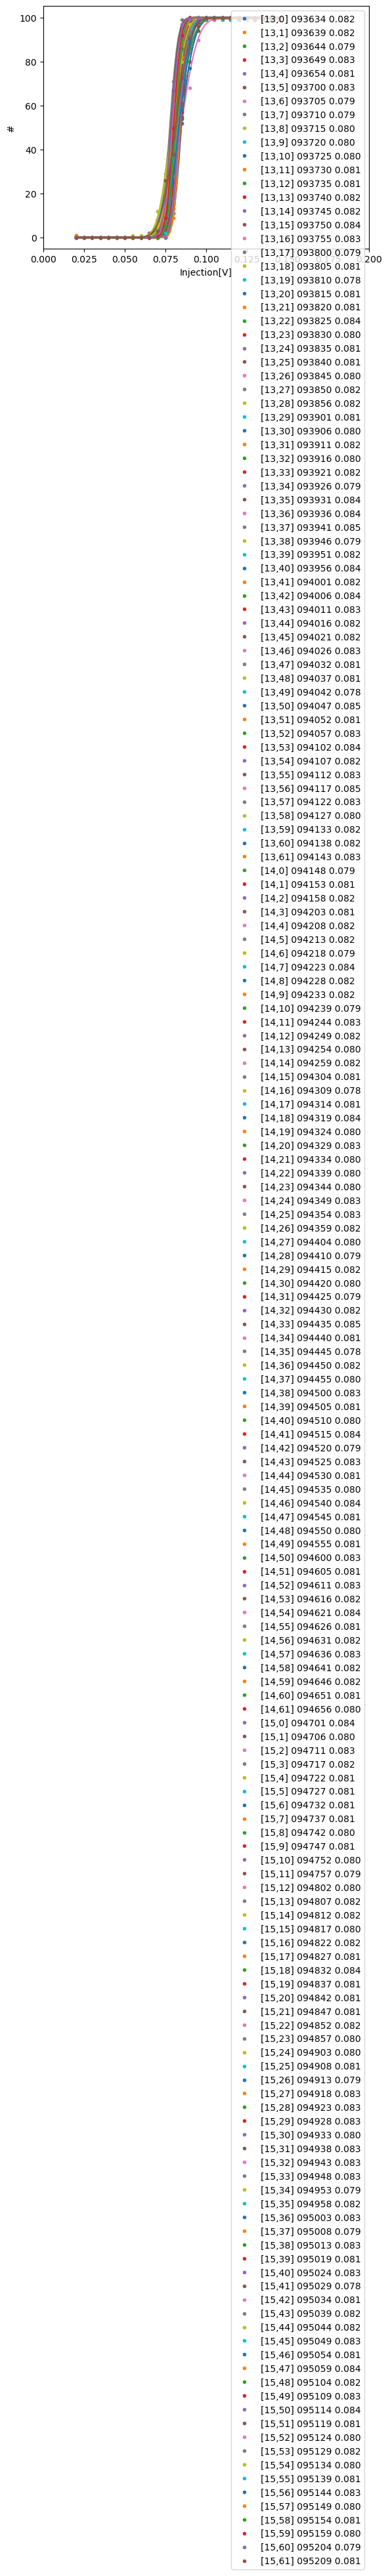

In [4]:
############ plot of all s curves Hui
## IPDAC 16 tuned TDAC
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan'
#datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/firsttuneslow/TunedScan'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        if fname in ['20240517_123825_injection_scan.h5']:
            continue
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret16_7 = plot_data(list_fraw)

##  Matrix

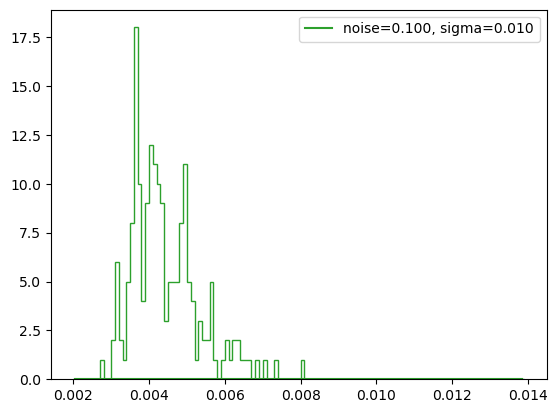

In [7]:
#### ivan try noise histogramm
bins = np.arange(0.002,0.014,0.0001)
x = (bins[:-1]+bins[1:])/2.0

tmp = ret16_7[ret16_7['row']>0]

hist = plt.hist(tmp['th_err'], bins=bins,
               histtype="step", color='C2')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="noise={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C2')


plt.legend()

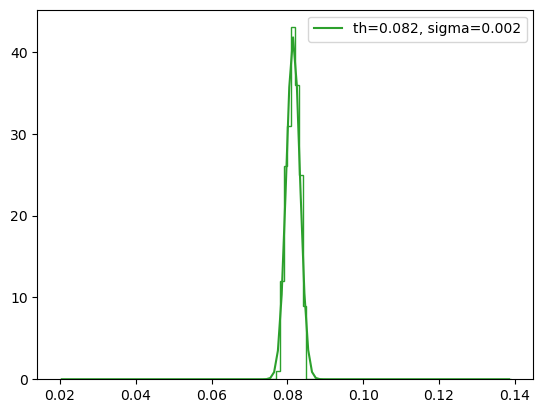

In [6]:
#### ivan try histogramm
bins = np.arange(0.02,0.14,0.001)
x = (bins[:-1]+bins[1:])/2.0

tmp = ret16_7[ret16_7['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C2')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C2')


plt.legend()

In [ ]:
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V   Matrix!!!
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), 
                            #('IPDAC', 'i')
        ]
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        #print(fname)
        list_fraw.append(os.path.join(datdir, fname))
t0 = time.time()
ret0=np.empty(len(list_fraw), dtype=dtype)    ##should change ret
for i, fraw in enumerate(list_fraw):
    ret0[i] = plot_data_png([fraw])           ##should change ret
    if i%100==0:
        print('time for calculation ({0}/{1}) {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             )

In [ ]:
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
os.makedirs(os.path.join(datdir,'results'))
np.save(os.path.join(os.path.join(datdir,'results'), 'th_tdac0.npy'), ret0)

In [ ]:
bins = np.arange(0.02,0.14,0.001)
x = (bins[:-1]+bins[1:])/2.0

#####
tmp = ret[ret['row']>0]
hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C0');
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C0')
####
tmp = ret0[ret0['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C1')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="tdac={0:.0f}, th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C1')



####
tmp = ret1[ret1['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C2')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C2')


plt.legend()

In [ ]:
tmp[['col','row','th']][tmp['th']>0.09]

In [ ]:
Z = np.random.rand(6, 10)
len(Z)

In [ ]:
## get data from hit file (event_data)
#fname = os.path.basename(fraw)
fraw = os.path.join(datdir,'20240315_123118_injection_scan.h5')
fhit = fraw[:-7] + 'hit.h5'

with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator1
dat1 = dat[dat['comp']==1]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(param['inj'], nhit1, '.-')

xbins = np.arange(param['inj'][0]-(param['inj'][-1]-param['inj'][-2])/2, 
                  param['inj'][-1]+(param['inj'][-1]+param['inj'][-2])/2,
                  param['inj'][-1]-param['inj'][-2])
                  

ax[1].hist2d(param[dat1['event_number']]['inj'], dat1['tot'], 
           bins=[xbins, np.arange(1, 2048,10)]);
ax[0].set_xlim(0,0.7)

In [ ]:
fraw = os.path.join(datdir,'20240315_123507_injection_scan.h5')
fhit = fraw[:-7] + 'hit.h5'

with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator1
dat1 = dat[dat['comp']==1]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(param['inj'], nhit1, '.-')

xbins = np.arange(param['inj'][0]-(param['inj'][-1]-param['inj'][-2])/2, 
                  param['inj'][-1]+(param['inj'][-1]+param['inj'][-2])/2,
                  param['inj'][-1]-param['inj'][-2])
                  

ax[1].hist2d(param[dat1['event_number']]['inj'], dat1['tot'], 
           bins=[xbins, np.arange(1, 2048,10)]);
ax[0].set_xlim(0,0.7)

In [ ]:
list_fraw = []
list_fraw.append(os.path.join(datdir, '20240314_104621_injection_scan.h5'))  # TDAC= 7 IPDAC=8 VComp2=10
list_fraw.append(os.path.join(datdir, '20240314_104641_injection_scan.h5'))  # TDAC= 0 IPDAC=8 VComp2=10
list_fraw.append(os.path.join(datdir, '20240314_104748_injection_scan.h5'))  # TDAC= 3 IPDAC=12 VComp2=16

#list_fraw.append(os.path.join(datdir, '20240308_125247_injection_scan.h5'))  # TDAC=7 IPDAC=12 VComp2=32
#list_fraw.append(os.path.join(datdir, '20240308_123703_injection_scan.h5'))  # TDAC=7 IPDAC=4
#list_fraw.append(os.path.join(datdir, '20240308_124602_injection_scan.h5'))  # TDAC=3 IPDAC=4

plot_data(list_fraw)